# Predicting Golf Scores Using Key Golfer Performance Indicators

In this notebook I will be exploring how key indicators contribute towards a final golfer ranking for the PGA season 2017. This information will help to determine how professional golfers can tailor their training to maximise performance on the PGA tour. 

Dataset for this notebook was downloaded from Kaggle and can be found at the following link:

https://www.kaggle.com/grantruedy/pga-tour-golf-data-2017-season

# Imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import plotly.figure_factory as ff
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
import plotly.graph_objects as go

#import os

#from optbinning import OptimalBinning
#import math
#from plotly.subplots import make_subplots

#import plotly.express as px
#from sklearn.cluster import KMeans
#from sklearn.preprocessing import OrdinalEncoder
#import statsmodels.api as sm
#from statsmodels.discrete.discrete_model import Logit
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import roc_auc_score, recall_score, precision_score, accuracy_score, confusion_matrix
#from sklearn import tree, svm
#import graphviz
#from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
#from sklearn.ensemble import RandomForestClassifier

# Functions

In [3]:
def DistributionPlot(Df, PlotVar, Split = None):
    '''
    Plots the distribution of a given variable in a dataframe
    '''
    Labels = [i for i in range(0, 100, 10)]
    
    BinSize = Df[PlotVar].describe().loc["std"] / 20
    
    if Split != None:
        fig = ff.create_distplot(
                hist_data = [Df[Df[Split] == 0][PlotVar].values, Df[Df[Split] == 1][PlotVar].values]
                , group_labels = [str(Split) + " = 0", str(Split) + " = 1"]
                , bin_size=BinSize
                , show_hist=True)

    fig = ff.create_distplot(
        hist_data = [Df[PlotVar].values]
        , group_labels = ["All"]
        , bin_size=BinSize
        , show_hist=True)

    fig.update_xaxes(
    zeroline = True
    , showgrid = True
    , title=PlotVar)


    fig.update_yaxes(
        zeroline=True
        , showgrid=True
        , title="Distribution")


    fig.update_layout(
        title = dict(text=str(PlotVar) + " Distribution"
                     , font=dict(color="Black", size=20))
        , font = dict(color="Black", size=10)
        , height = 700
        , width = 1100
        , legend_title='Target')

    fig.show(renderer='png', height=700, width=1100)

In [4]:
def Scatter(Df, PlotVar, Y, Title):
    
    '''

    '''

    fig = go.Figure()

    fig.add_trace(  
        go.Scatter(
            x = Df[PlotVar]
            , y=Df[Y]
            , mode='markers'
            , line=dict(color='red')
            , marker=dict(size=10)
            , showlegend= False))

    fig.update_xaxes(
        zeroline = True
        , showgrid = True
        , title = PlotVar)

    fig.update_yaxes(
        zeroline=True
        , showgrid=True
        , title = Y)
    
    
    fig.update_layout(
        title = dict(text=Title, font=dict(size=17)))

    fig.update_annotations(
        font = dict(size=14))
    
    fig.show(renderer="png", height=600, width=1000)

# Preprocessing

## Explanation

To start we will split our Data into a shuffled Train and Test set, in order to allow a sufficient model validation process.

In order for this model to determine key success indicators in the game of golf, we will need to define a new variable as points per round, which makes a fair assessment of ability, rather than just raw points scored.

We will also remove columns containing information that does not contribute towards golfer ability, things like Number of Wins, Number of top tens etc. These columns will correlate highly with our target and using them to predict performance will introduce a concept called look-ahead bias.

In [5]:
Data = pd.read_csv(r"Data\PGATOUR_data2.csv")
Data = Data.dropna()
Data = Data.drop(["NUMBER_OF_WINS", "NUMBER_OF_TOP_Tens", "POINTS_BEHIND_LEAD"], axis = 1)
Data = Data[Data["EVENTS_PLAYED"] > 5]
Data["POINTS_PER_ROUND"] = Data["POINTS"] / Data["ROUNDS_PLAYED"]
Data["TOTAL_DRIVES"] = Data["TOTAL_DRIVES"].apply(lambda x: x.replace(",", "")).astype("float") 
Data["FAIRWAYS_HIT"] = Data["FAIRWAYS_HIT"].apply(lambda x: x.replace(",", "")).astype("float") 
Data["LOG_POINTS_PER_ROUND"] = np.log(Data["POINTS_PER_ROUND"])

Train, Test = train_test_split(Data, test_size=0.33, random_state=42)

# EDA

## Explanation

Starting with an initial play around with the data, we see that there are 69 columns describing the 2017 season for 194 players. We have split the Data into a Train:Test ratio of arround 2:1. There are also no-null values which makes for an easier preprocessing stage.

In [6]:
Train.head()

,Player,EVENTS_PLAYED,POINTS,ROUNDS_PLAYED,SG_PUTTING_PER_ROUND,TOTAL_SG:PUTTING,MEASURED_ROUNDS,AVG_Driving_DISTANCE,UP_AND_DOWN_%,PAR_OR_BETTER,...,SHORTEST_CARRY_DISTANCE,AVG_SCORE,TOTAL_STROKES,TOTAL_ROUNDS,MAKES_BOGEY%,BOGEYS_MADE,HOLES_PLAYED,AGE,POINTS_PER_ROUND,LOG_POINTS_PER_ROUND
133,Patrick Rodgers,30.0,541.0,97.0,0.596,41.152,69.0,303.4,58.14,318.0,...,246.2,70.731,6572.0,93.0,16.79,281.0,1674.0,26.0,5.577320,1.718708
101,Kevin Chappell,23.0,667.0,77.0,-0.406,-23.544,58.0,308.8,58.50,241.0,...,259.1,70.839,5243.0,74.0,17.87,238.0,1332.0,31.0,8.662338,2.158985
26,Brian Gay,29.0,910.0,99.0,0.480,40.290,84.0,282.8,63.93,381.0,...,236.0,70.280,7062.0,101.0,14.96,272.0,1818.0,46.0,9.191919,2.218325
129,Padraig Harrington,16.0,29.0,46.0,-0.179,-5.742,32.0,300.1,56.32,156.0,...,244.8,70.890,5329.0,75.0,16.48,222.0,1359.0,47.0,0.630435,-0.461346
187,Wesley Bryan,23.0,219.0,69.0,0.360,18.354,51.0,280.4,60.17,281.0,...,234.5,71.552,4770.0,67.0,17.25,208.0,1206.0,32.0,3.173913,1.154965


In [7]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129 entries, 133 to 103
Data columns (total 68 columns):
Player                       129 non-null object
EVENTS_PLAYED                129 non-null float64
POINTS                       129 non-null float64
ROUNDS_PLAYED                129 non-null float64
SG_PUTTING_PER_ROUND         129 non-null float64
TOTAL_SG:PUTTING             129 non-null float64
MEASURED_ROUNDS              129 non-null float64
AVG_Driving_DISTANCE         129 non-null float64
UP_AND_DOWN_%                129 non-null float64
PAR_OR_BETTER                129 non-null float64
MISSED_GIR                   129 non-null float64
FAIRWAY_HIT_%                129 non-null float64
FAIRWAYS_HIT                 129 non-null float64
POSSIBLE_FAIRWAYS            129 non-null float64
GIR_RANK                     129 non-null float64
GOING_FOR_GREEN_IN_2%        129 non-null float64
ATTEMPTS_GFG                 129 non-null float64
NON-ATTEMPTS_GFG             129 non-null fl

In [8]:
Train.shape

(129, 68)

### Dependent Variable Distributions

I first plot the distribution of the dependent variable to help visualise and also inspect any interesting areas such as outliers. Dustin Johnson seems to have score over 10 points per round more than any other player, while this seems quite high, we have no evidence that this is a measurement error, we will keep it in.

The distribution of our target variable seems to be skewed to the right, meaning that may cause issues with the prediction. It might be beneficial to take the logarithm of the target in order to help with predictions. 

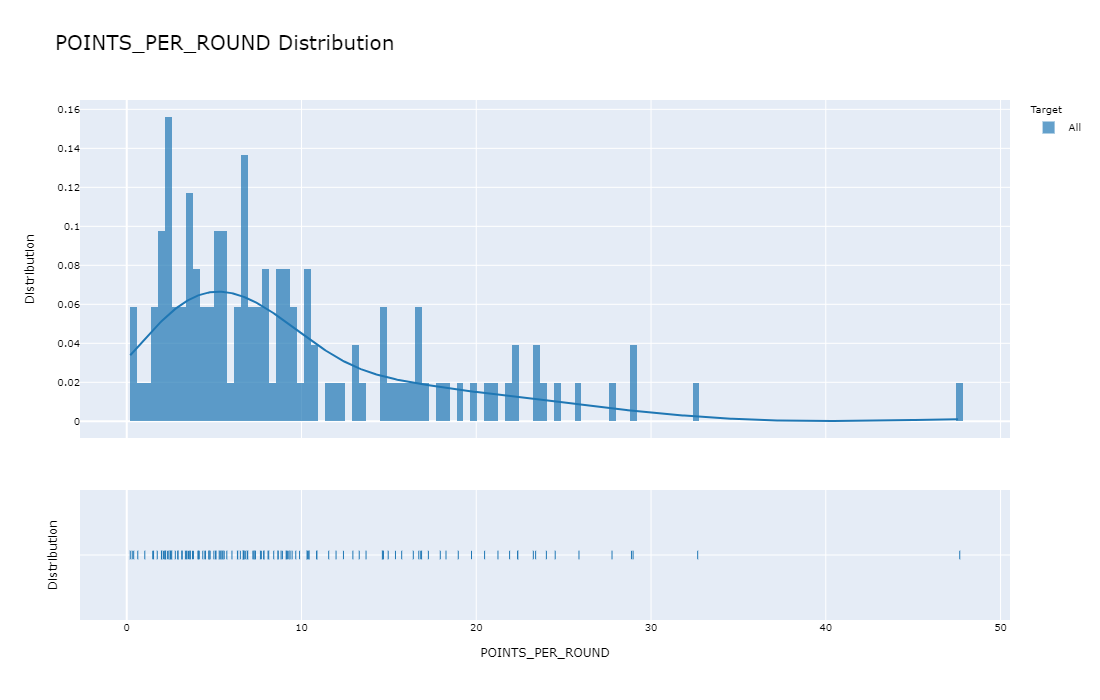

In [9]:
DistributionPlot(Train, "POINTS_PER_ROUND")

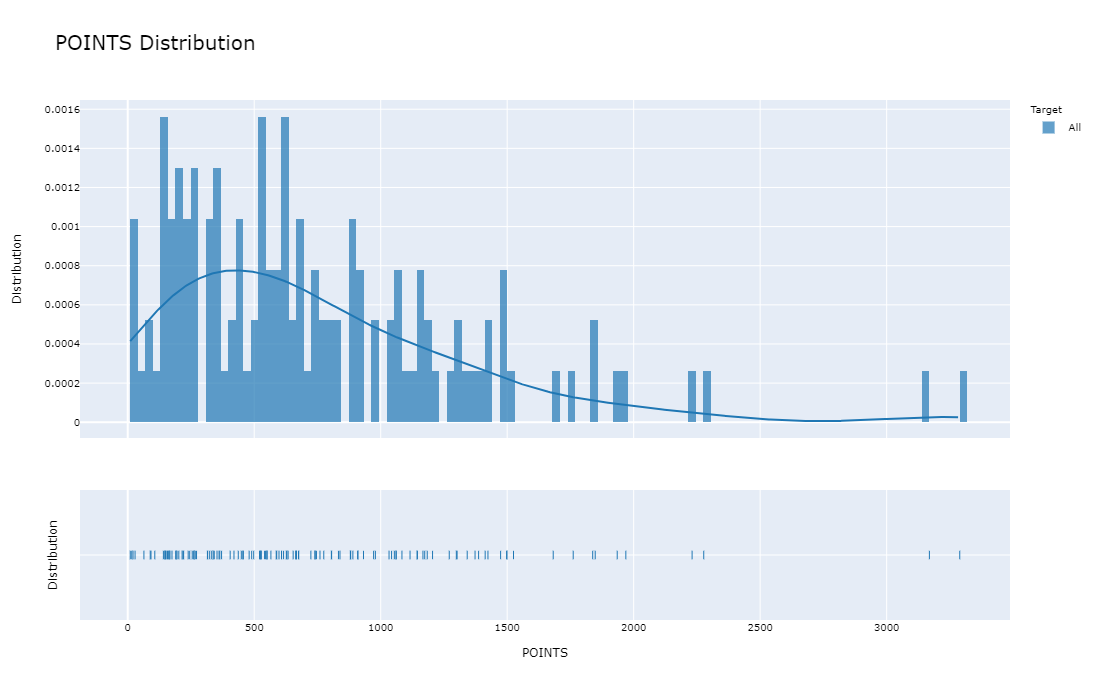

In [10]:
DistributionPlot(Train, "POINTS")

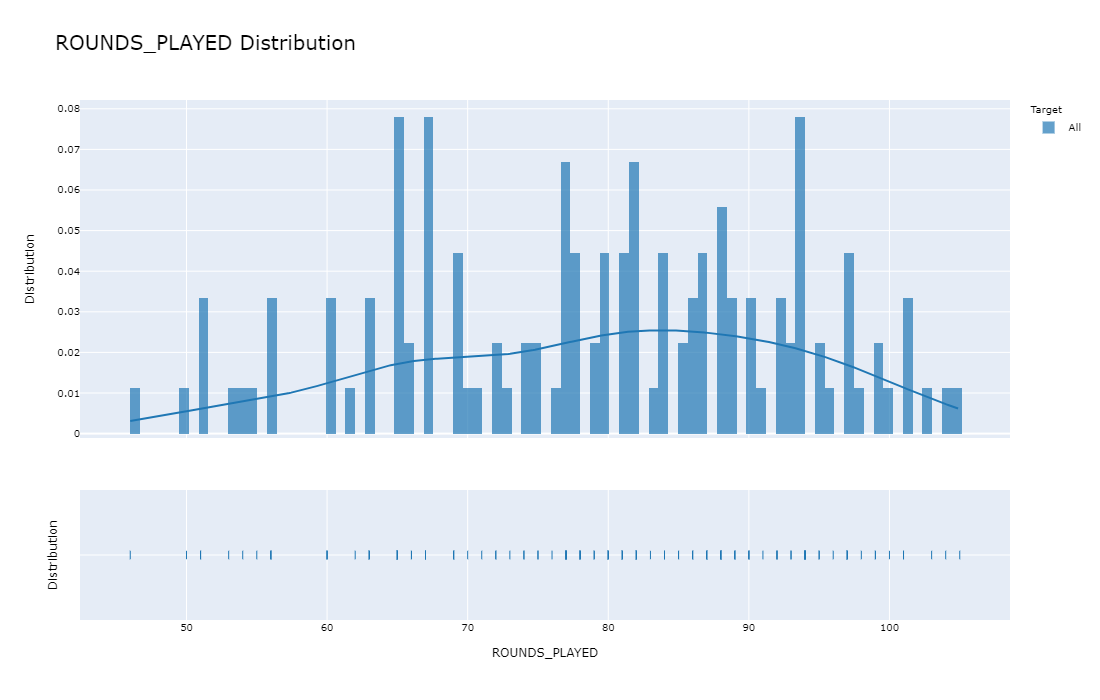

In [11]:
DistributionPlot(Train, "ROUNDS_PLAYED")

In [12]:
Train.sort_values("POINTS_PER_ROUND", ascending=False)[["Player", "EVENTS_PLAYED", "POINTS", "ROUNDS_PLAYED", "POINTS_PER_ROUND"]].head()

,Player,EVENTS_PLAYED,POINTS,ROUNDS_PLAYED,POINTS_PER_ROUND
60,Dustin Johnson,18.0,3289.0,69.0,47.666667
179,Tony Finau,26.0,3169.0,97.0,32.670103
38,Cameron Smith,22.0,2231.0,77.0,28.974026
82,Jason Day,18.0,1935.0,67.0,28.880597
33,Bubba Watson,22.0,2277.0,82.0,27.768293


### Log-Dependent Variable 
When we take the logarithm of the dependent variable, we see it resembles a normal distribution much more, which should help are model with predictions. In order to ensure this, we will consider both the raw and logarithmic target, and choose the model which reduces the prediction error.

N.B We will need to exponentially transorm our models logarithmic predictions in order to make them comparable with the predictions from the other model.

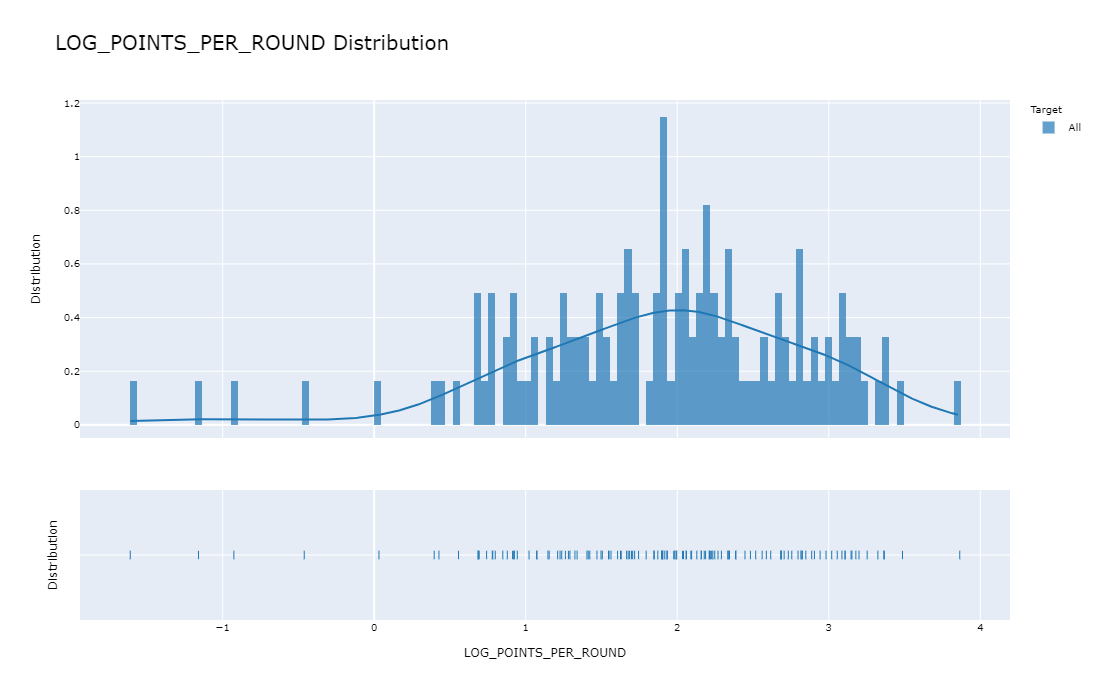

In [13]:
DistributionPlot(Train, "LOG_POINTS_PER_ROUND")

### Decision Tree Feature Selection
Because we have so many features to choose from, we will use Sklearns select from model feature to pick features based on thier importance in a Random Forest Model. The way this works is the model will fit hundreds of Decision Trees against our target variable, which will sample with selection from the feature and sample spaces. The feature importances will then be used to determine those with the strongest relationship with the target. We will take the top 50% of features by importance to consider for selection. Further selection will then be performed with EDA.

I have used some domain knowledge as well as the PGA tour website (where the date is from) to eliminate any features that are directly related to a golfers score. These are things like "number of saves", "number of birdies", "number above or below par" etc. This reduces lookahead bias.

In [14]:
X = ['AVG_Driving_DISTANCE', 'UP_AND_DOWN_%','MISSED_GIR', 
     'FAIRWAY_HIT_%', 'POSSIBLE_FAIRWAYS',
     'GIR_RANK', 'GOING_FOR_GREEN_IN_2%', 'ATTEMPTS_GFG',
     'NON-ATTEMPTS_GFG', 'HOLE_OUTS', 'SAND_SAVE%',
     'NUMBER_OF_BUNKERS', 'Three_PUTT%', 'TOTAL_3_PUTTS', 'DRIVES_320+%', 
     'TOTAL_DRIVES_FOR_320+', 'ROUGH_TENDNECY%', 
     'TOTAL_ROUGH', 'FAIRWAY_BUNKER%', 'TOTAL_FAIRWAY_BUNKERS', 
     'AVG_CLUB_HEAD_SPEED', 'FASTEST_CH_SPEED',
     'SLOWEST_CH_SPEED', 'AVG_BALL_SPEED', 'FASTEST_BALL_SPEED',
     'SLOWEST_BALL_SPEED', 'AVG_SMASH_FACTOR', 'HIGHEST_SF',
     'LOWEST_SF', 'AVG_LAUNCH_ANGLE', 'LOWEST_LAUNCH_ANGLE',
     'STEEPEST_LAUNCH_ANGLE', 'AVG_SPIN_RATE', 'HIGHEST_SPIN_RATE',
     'LOWEST_SPIN_RATE', 'AVG_HANG_TIME', 'LONGEST_ACT.HANG_TIME',
     'SHORTEST_ACT.HANG_TIME', 'AVG_CARRY_DISTANCE',
     'LONGEST_CARRY_DISTANCE', 'SHORTEST_CARRY_DISTANCE','AGE']

y = "LOG_POINTS_PER_ROUND"

Selecter = SelectFromModel(estimator = RandomForestRegressor(), threshold="median", max_features=20)
Selecter = Selecter.fit(Train[X].astype("int"), Train[y])
Index = Selecter.get_support()
print(str(len([i for i in Index if i == True])) + " Features have been selected")

ImportantFeatures = [X[i] for i in range(0, len(X)) if Index[i] == True]
print(ImportantFeatures)

Train = Train[["Player", "POINTS_PER_ROUND", "POINTS"] + [y] + ImportantFeatures]
Test = Test[["Player", "POINTS_PER_ROUND", "POINTS"] + [y] + ImportantFeatures]

20 Features have been selected
['UP_AND_DOWN_%', 'MISSED_GIR', 'FAIRWAY_HIT_%', 'POSSIBLE_FAIRWAYS', 'GIR_RANK', 'ATTEMPTS_GFG', 'NON-ATTEMPTS_GFG', 'NUMBER_OF_BUNKERS', 'TOTAL_3_PUTTS', 'DRIVES_320+%', 'TOTAL_DRIVES_FOR_320+', 'ROUGH_TENDNECY%', 'TOTAL_ROUGH', 'AVG_SPIN_RATE', 'HIGHEST_SPIN_RATE', 'LOWEST_SPIN_RATE', 'AVG_HANG_TIME', 'AVG_CARRY_DISTANCE', 'SHORTEST_CARRY_DISTANCE', 'AGE']


In [15]:
Train.head()

,Player,POINTS_PER_ROUND,POINTS,LOG_POINTS_PER_ROUND,UP_AND_DOWN_%,MISSED_GIR,FAIRWAY_HIT_%,POSSIBLE_FAIRWAYS,GIR_RANK,ATTEMPTS_GFG,...,TOTAL_DRIVES_FOR_320+,ROUGH_TENDNECY%,TOTAL_ROUGH,AVG_SPIN_RATE,HIGHEST_SPIN_RATE,LOWEST_SPIN_RATE,AVG_HANG_TIME,AVG_CARRY_DISTANCE,SHORTEST_CARRY_DISTANCE,AGE
133,Patrick Rodgers,5.577320,541.0,1.718708,58.14,547.0,60.92,1241.0,112.0,144.0,...,154.0,28.78,274.0,2731.1,4044.0,1745.0,6.5,290.3,246.2,26.0
101,Kevin Chappell,8.662338,667.0,2.158985,58.50,412.0,61.09,987.0,88.0,152.0,...,203.0,28.47,230.0,2654.9,5218.0,1506.0,6.7,291.9,259.1,31.0
26,Brian Gay,9.191919,910.0,2.218325,63.93,596.0,70.36,1299.0,147.0,113.0,...,28.0,21.84,268.0,2339.9,5462.0,1606.0,6.4,261.5,236.0,46.0
129,Padraig Harrington,0.630435,29.0,-0.461346,56.32,277.0,55.18,531.0,192.0,58.0,...,92.0,28.77,244.0,2633.7,5085.0,1737.0,6.3,278.2,244.8,47.0
187,Wesley Bryan,3.173913,219.0,1.154965,60.17,467.0,55.41,942.0,184.0,59.0,...,21.0,32.63,232.0,2389.0,4541.0,1427.0,5.9,265.4,234.5,32.0


## Distributions and Scatter Plots

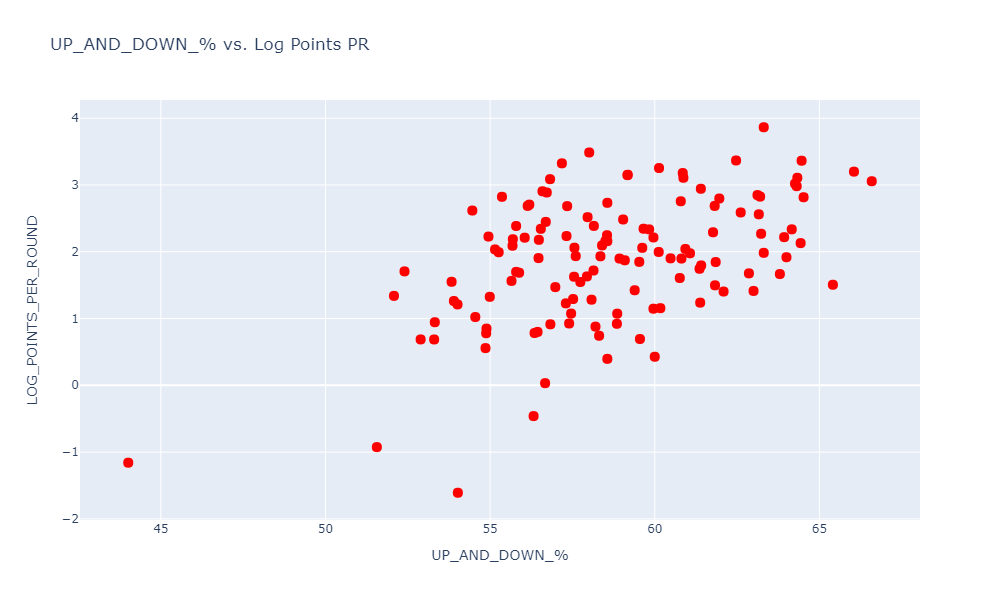

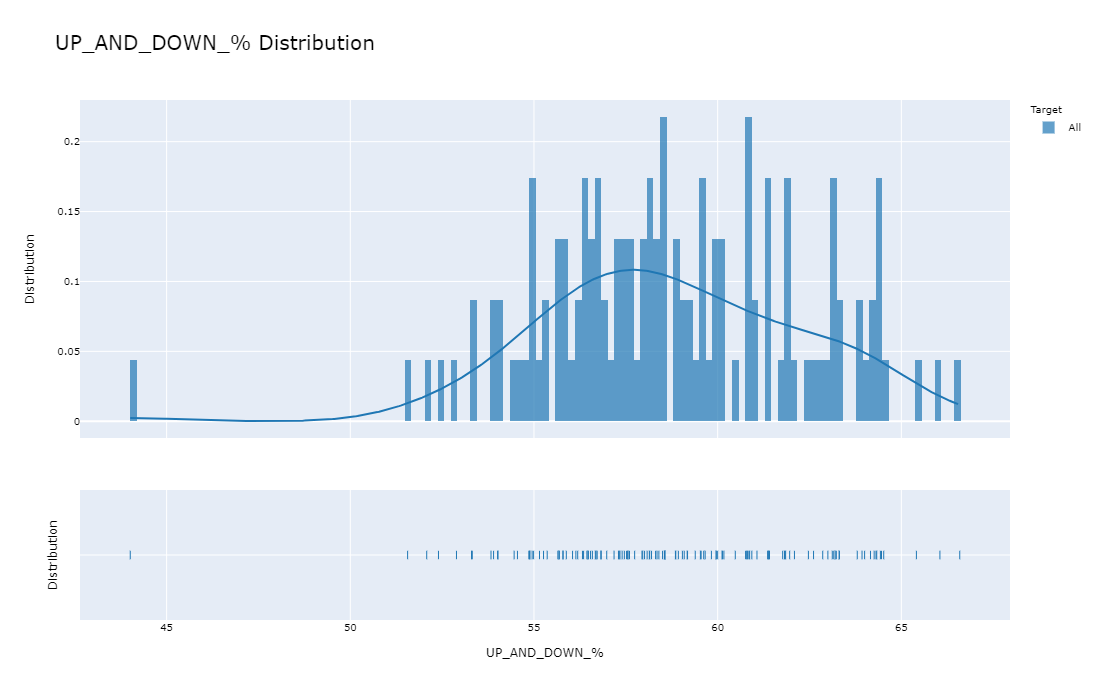

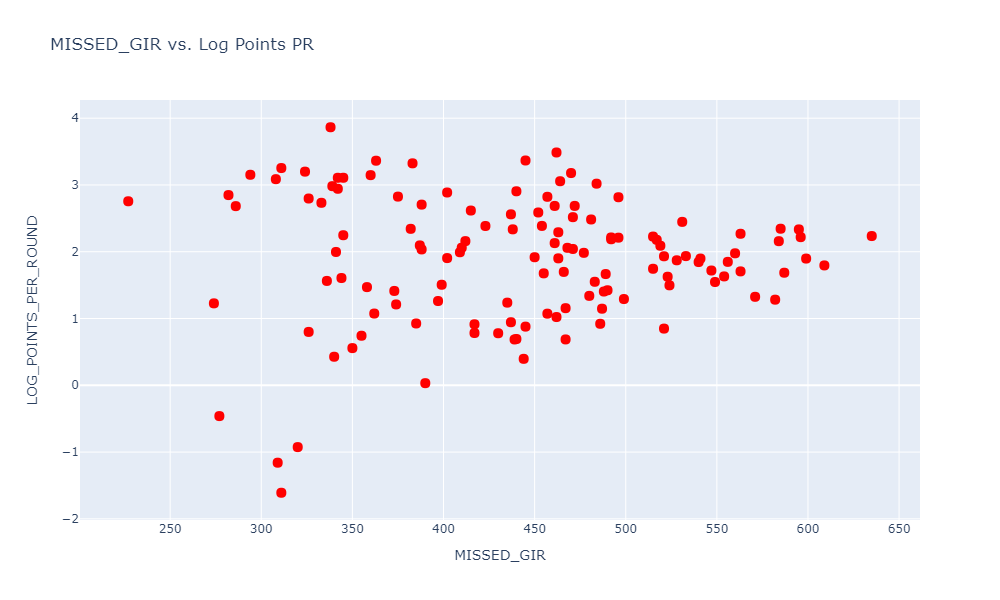

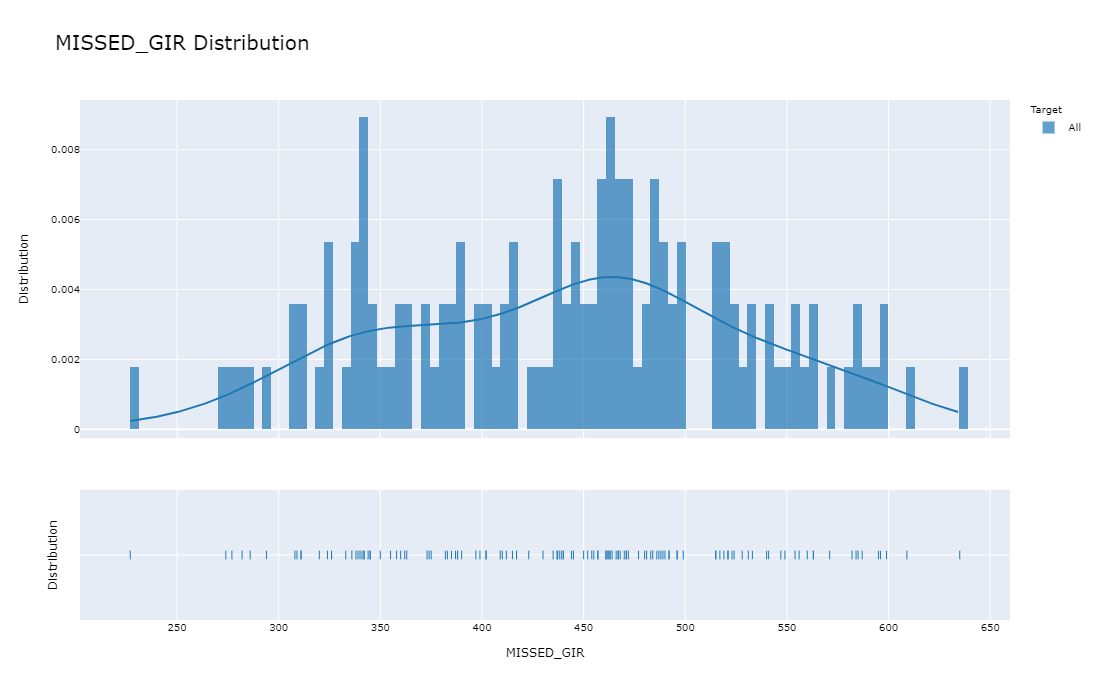

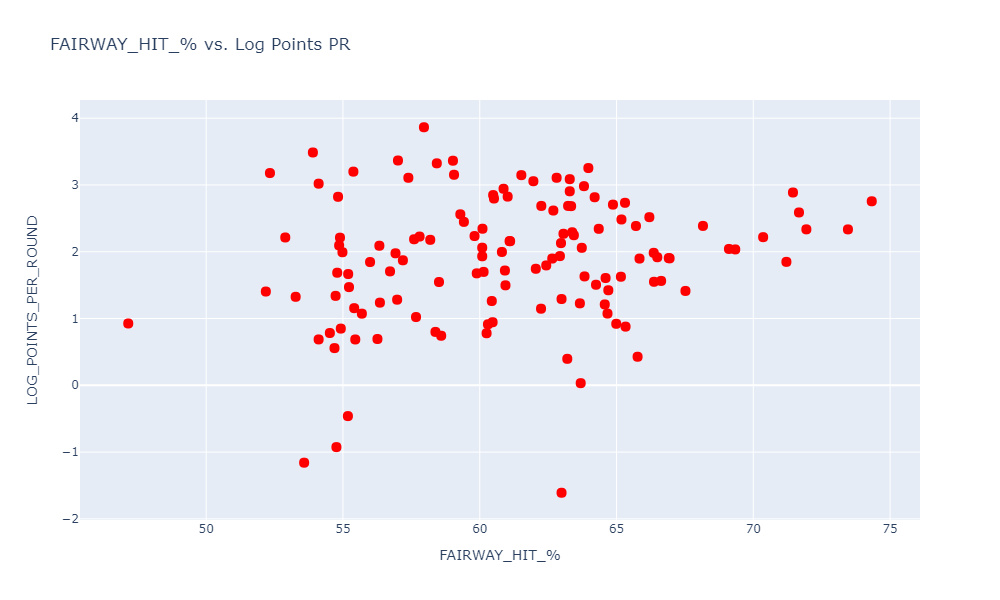

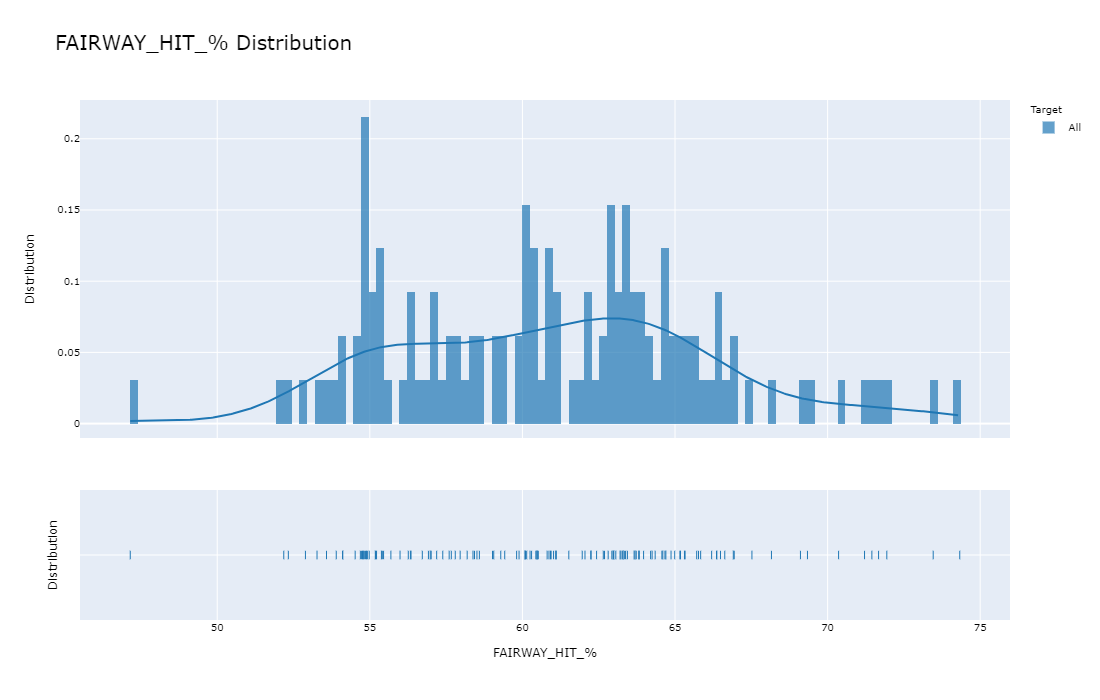

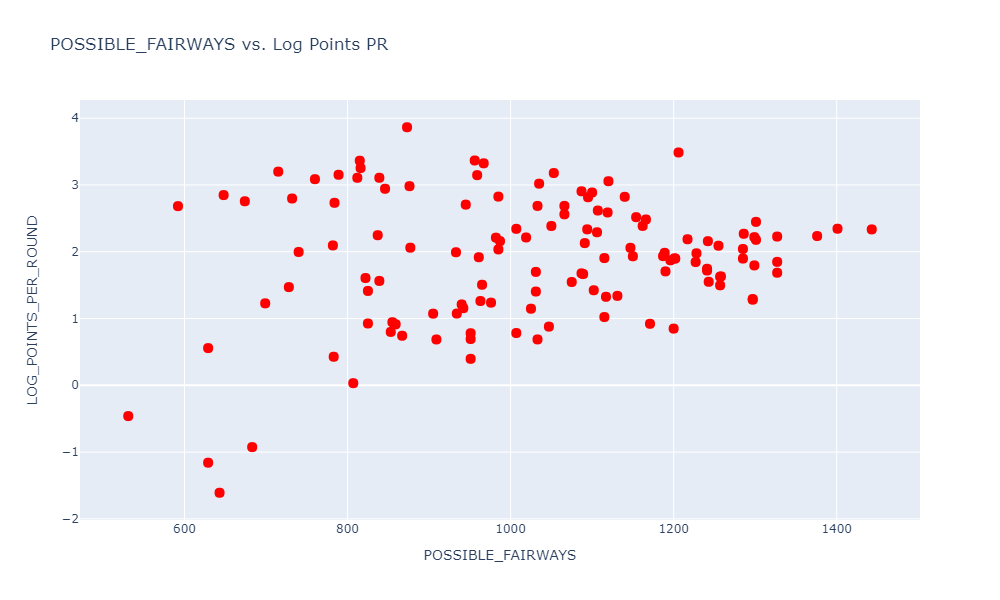

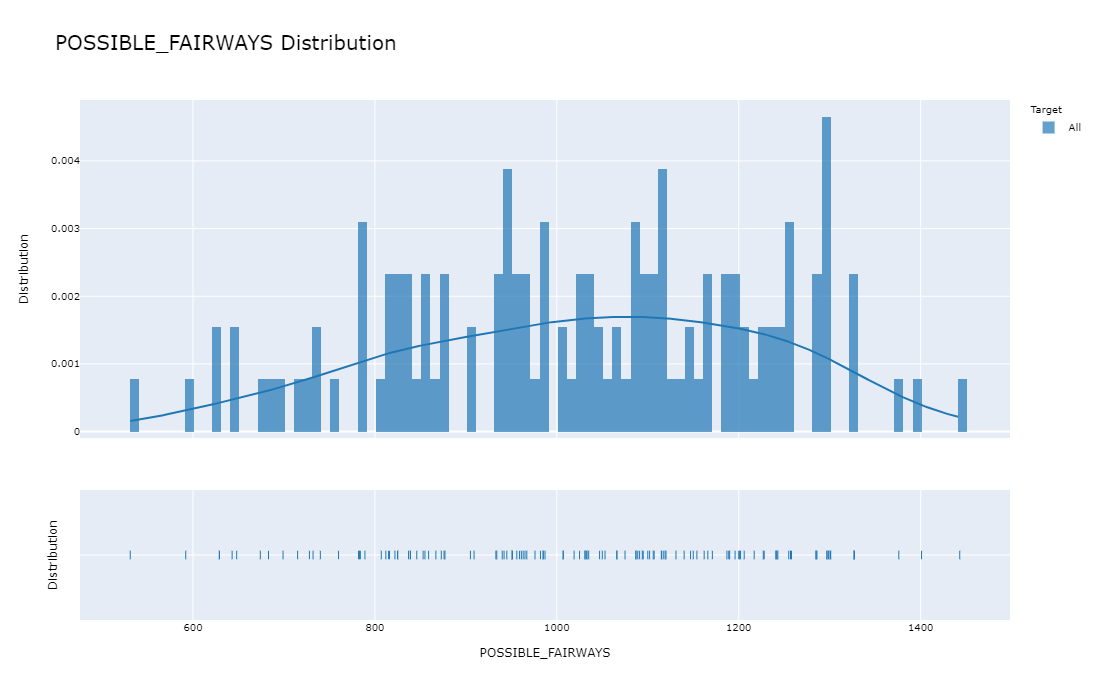

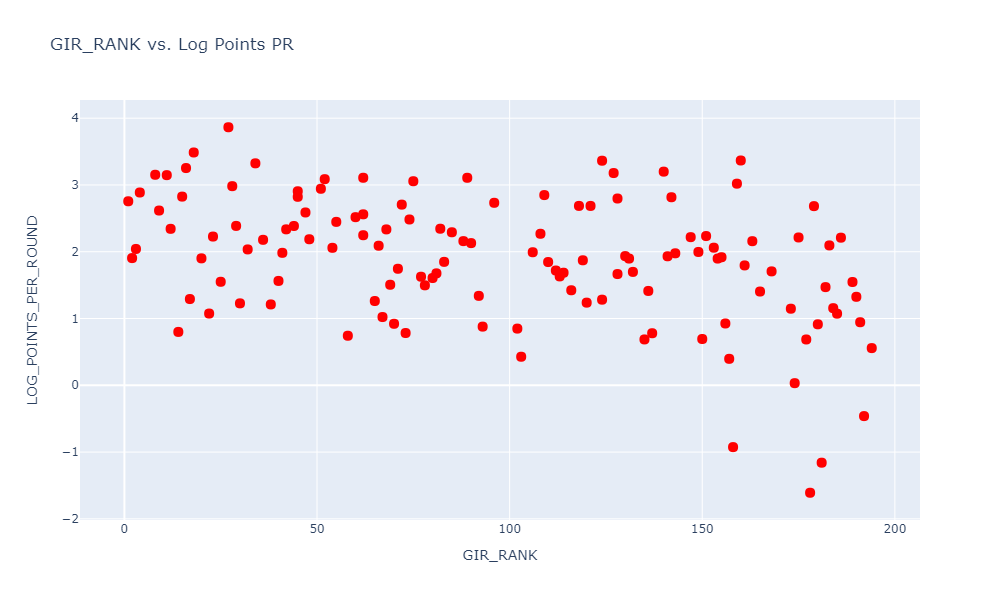

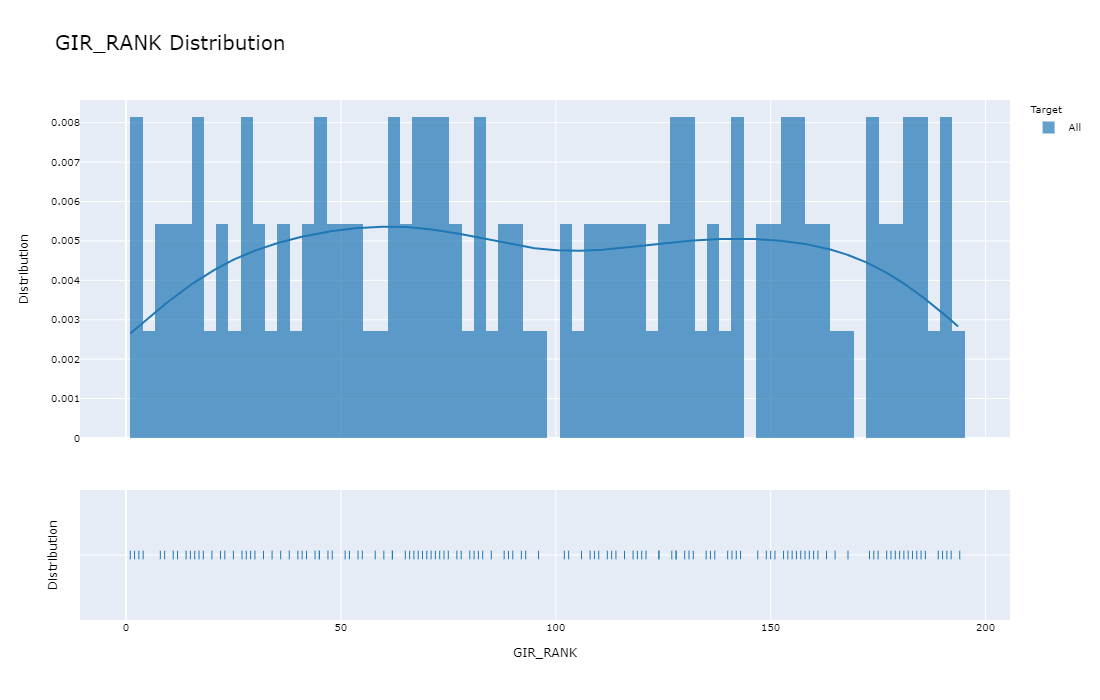

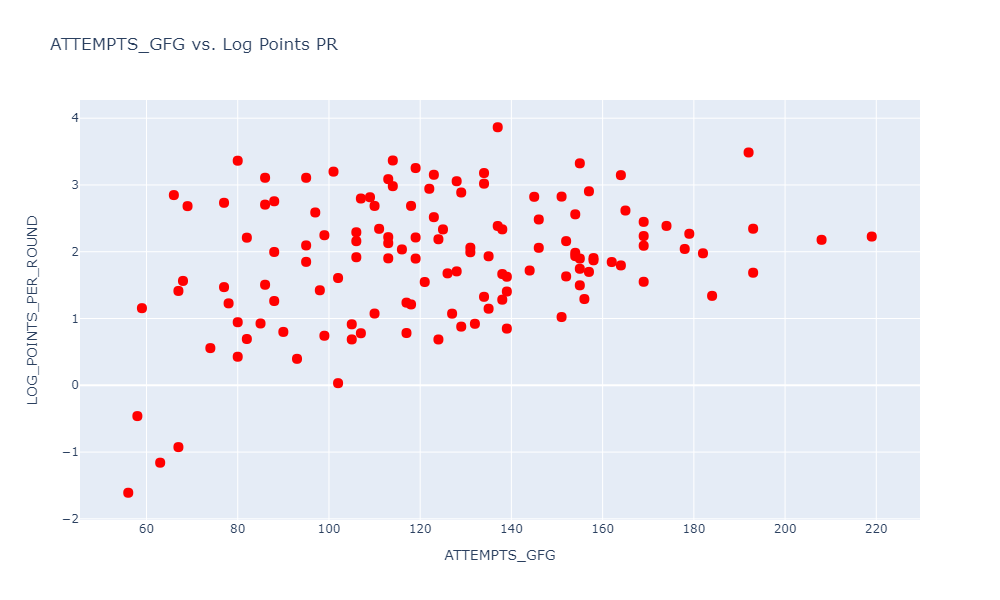

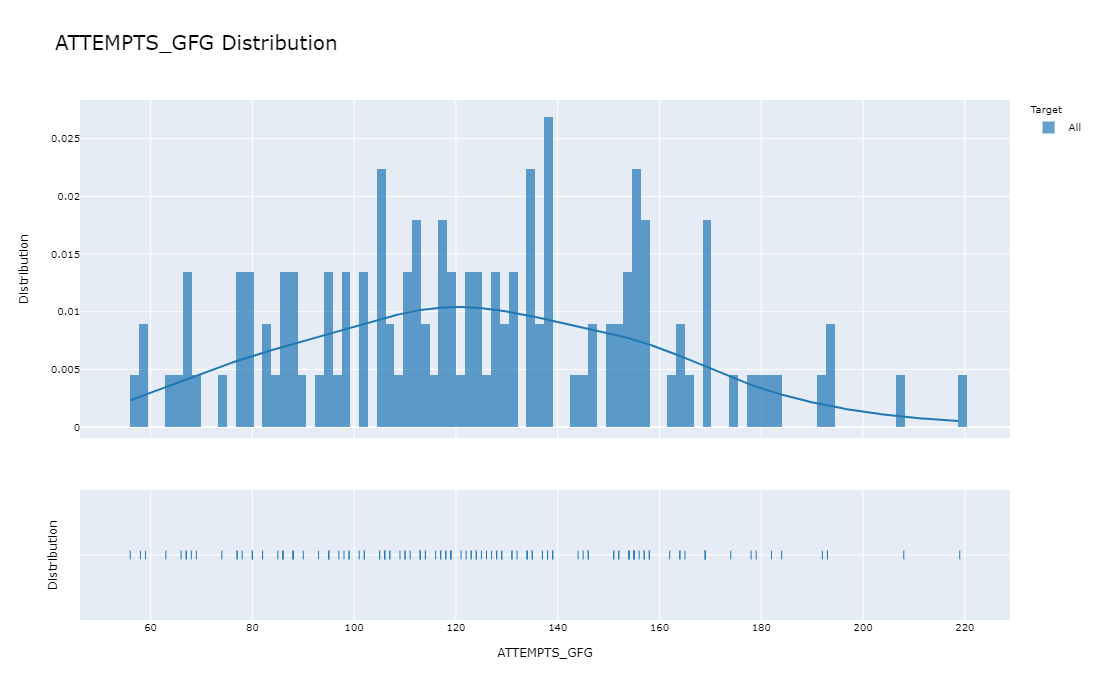

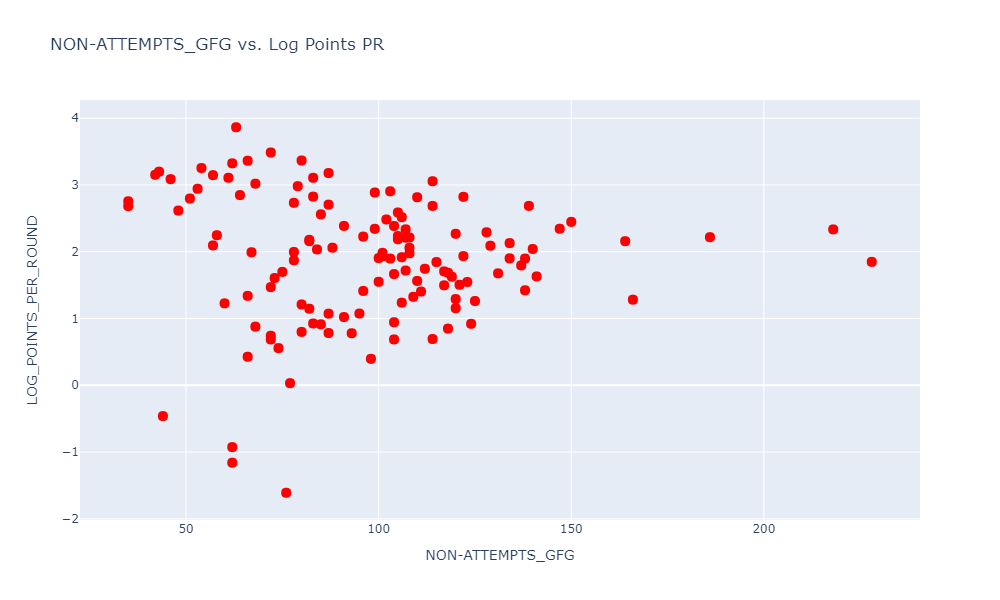

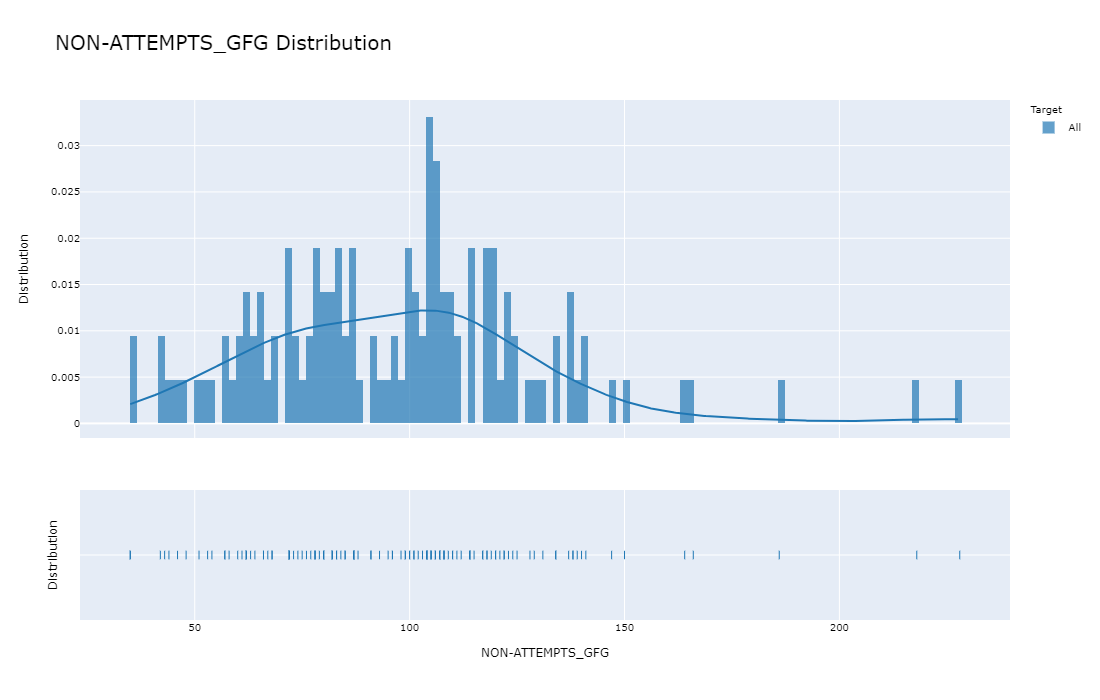

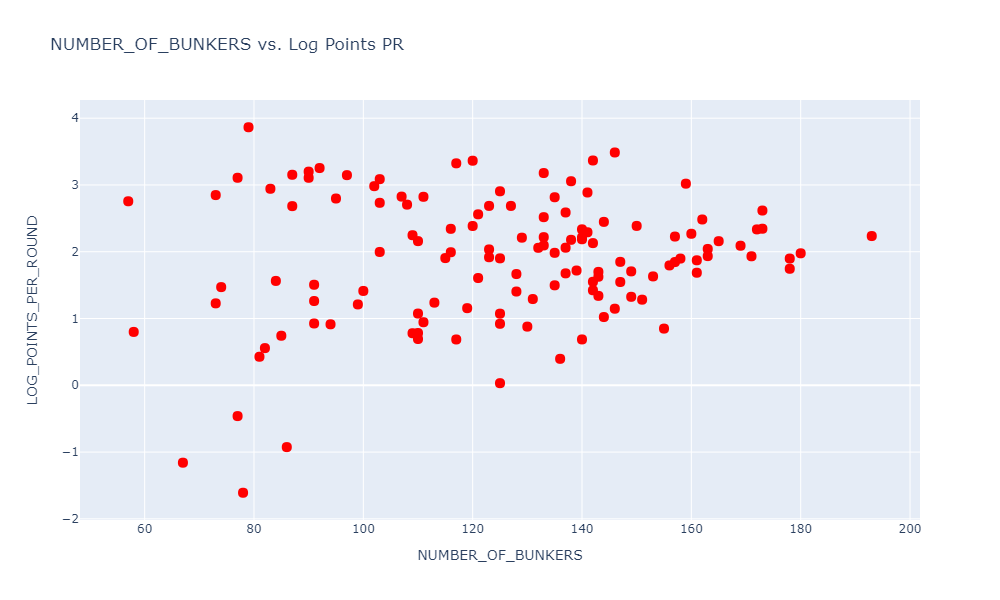

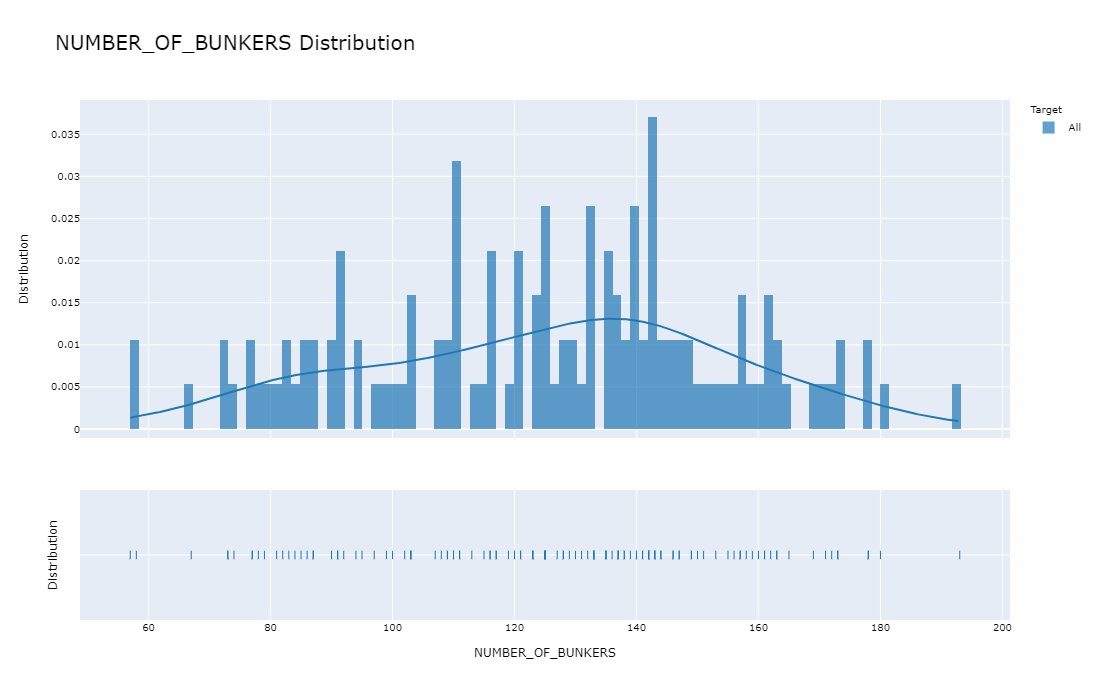

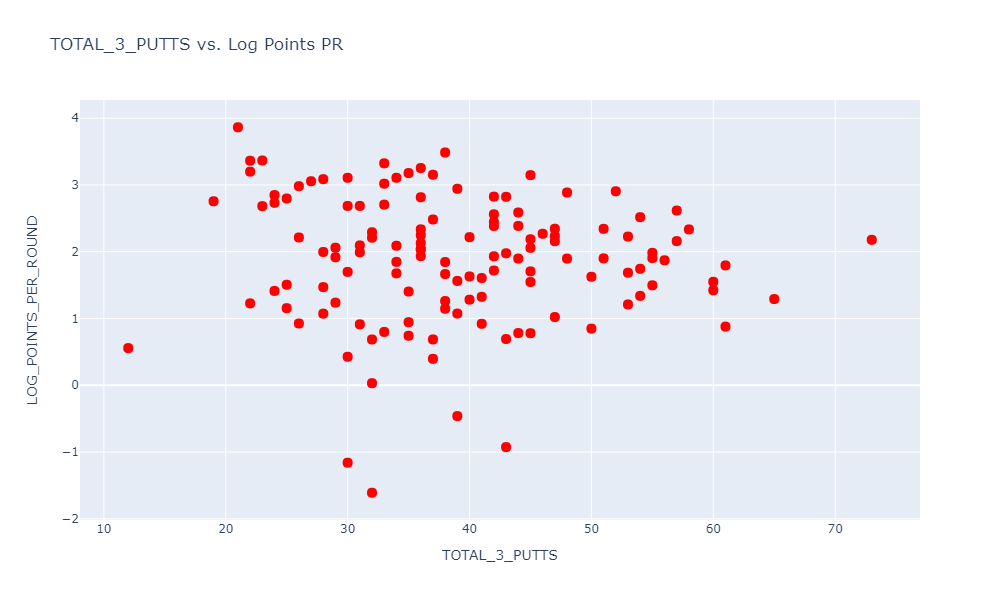

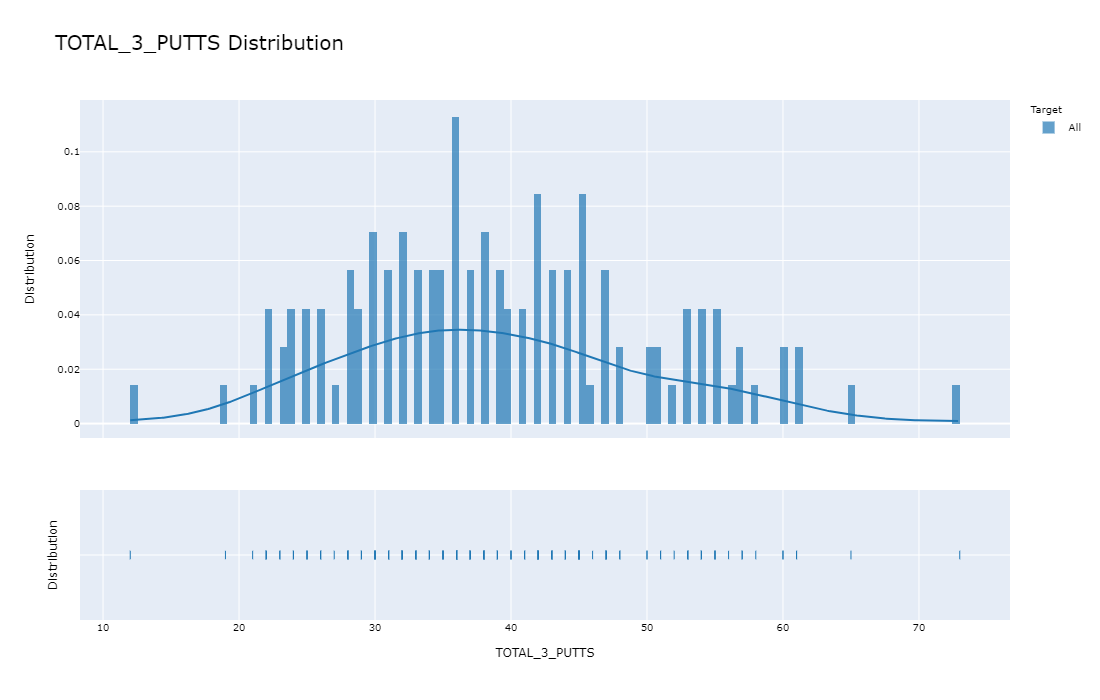

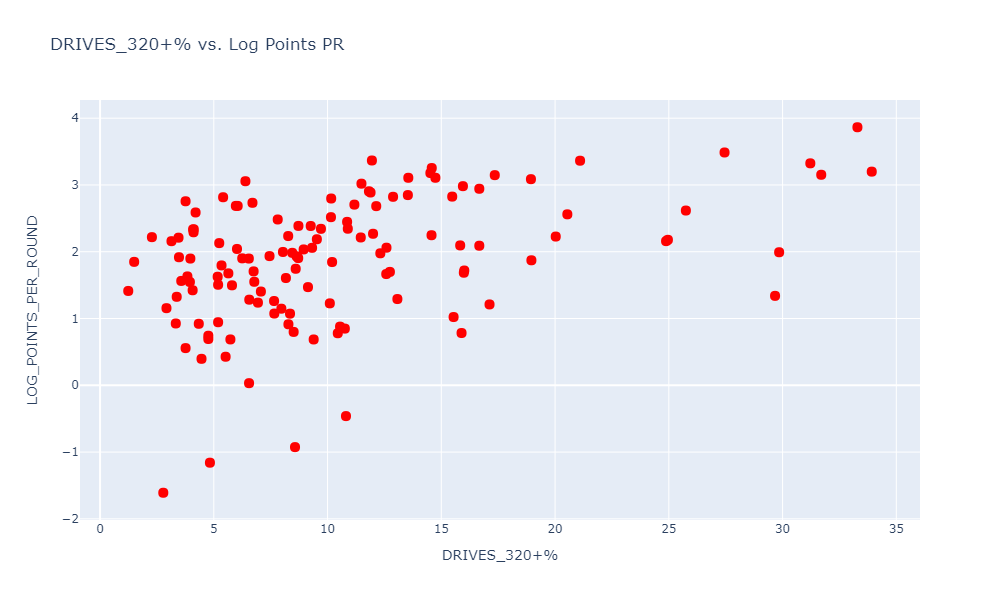

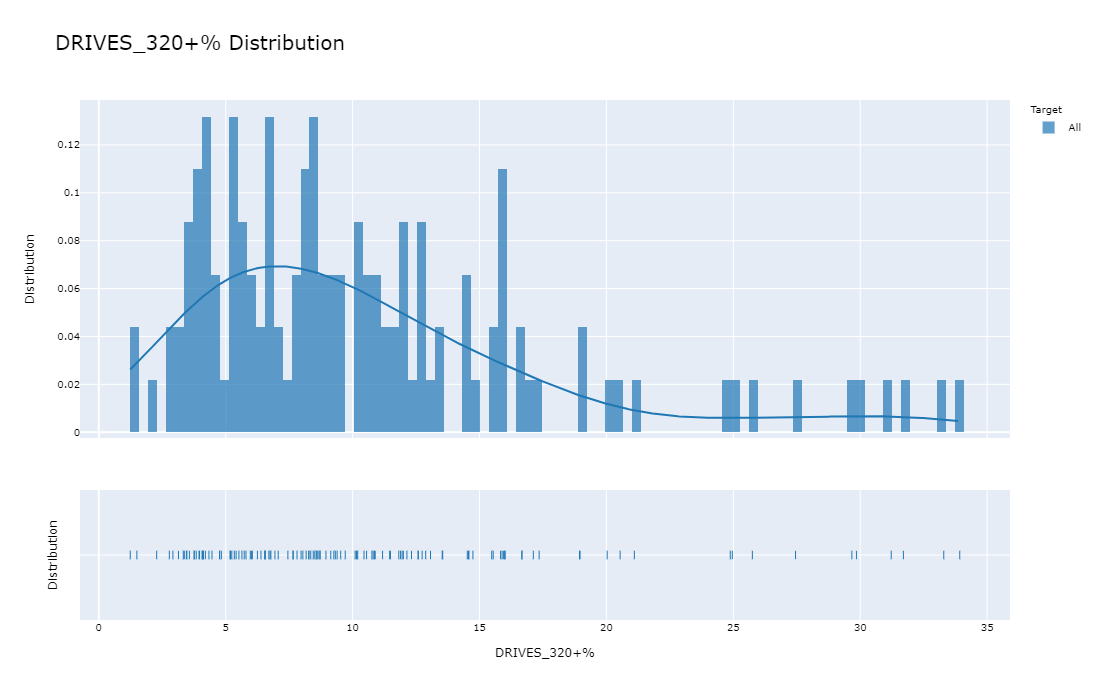

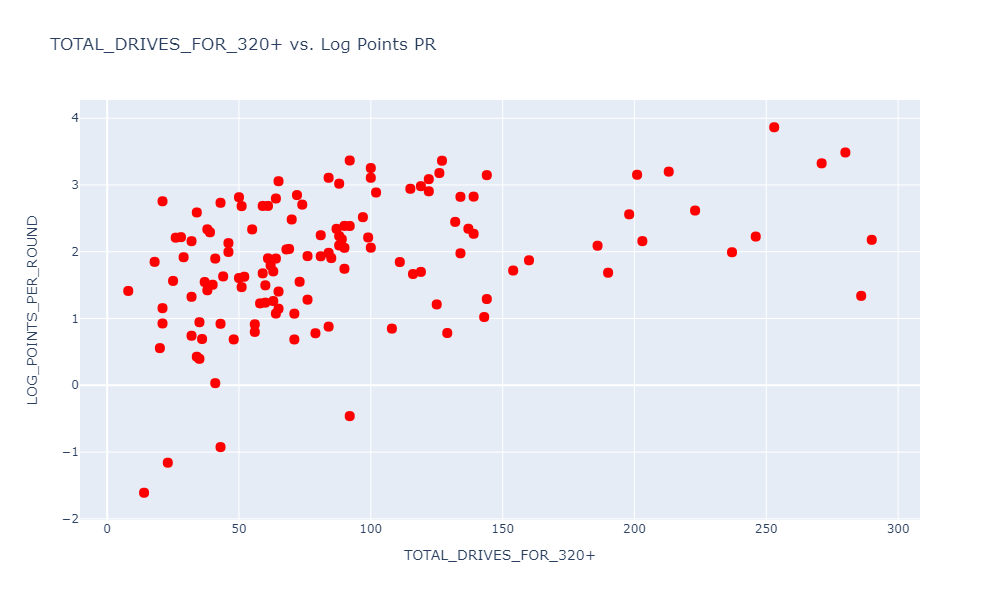

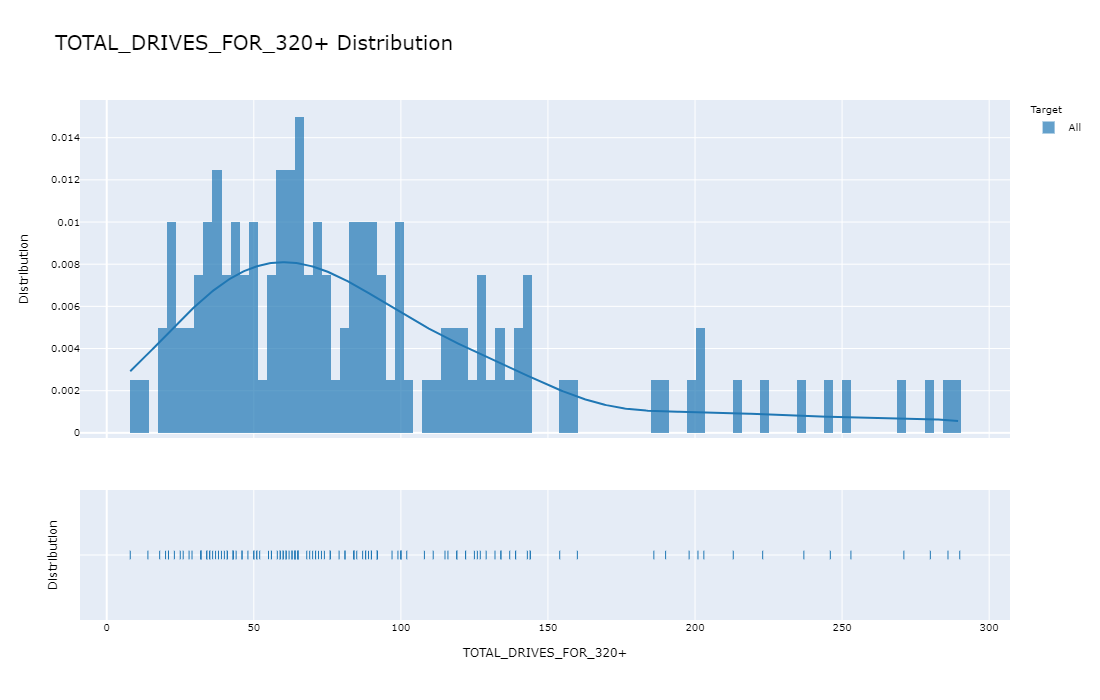

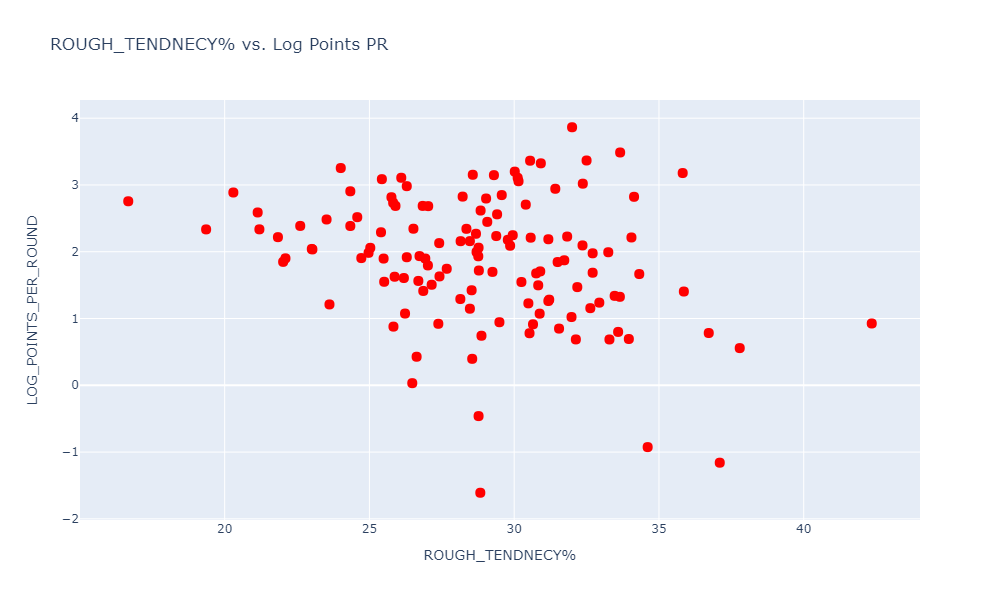

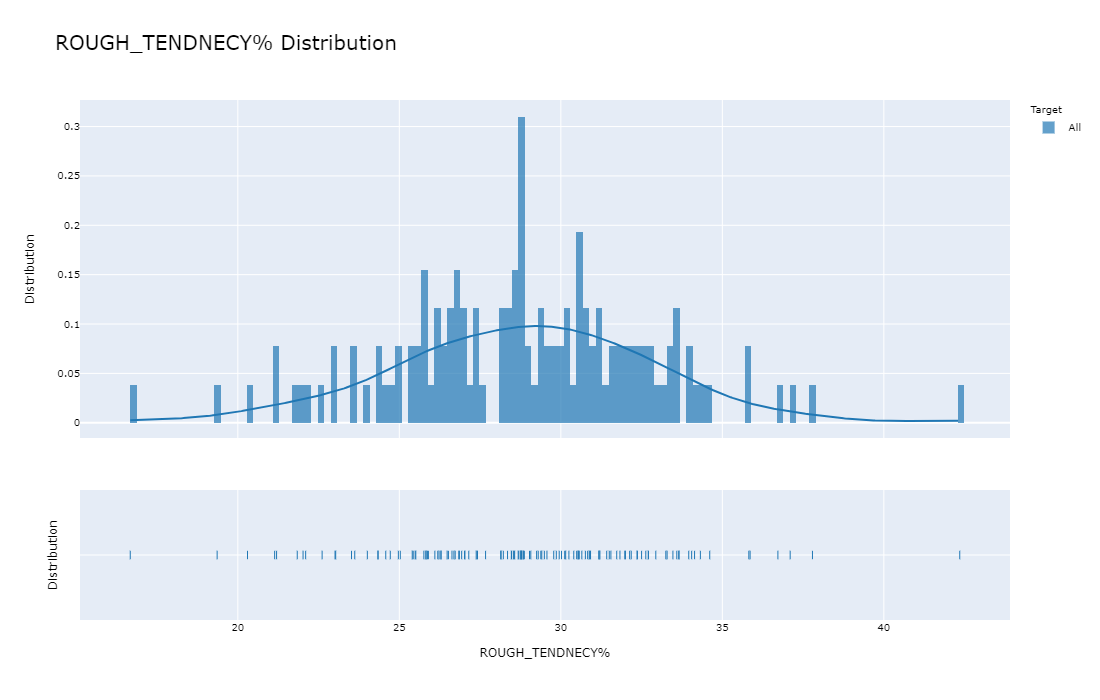

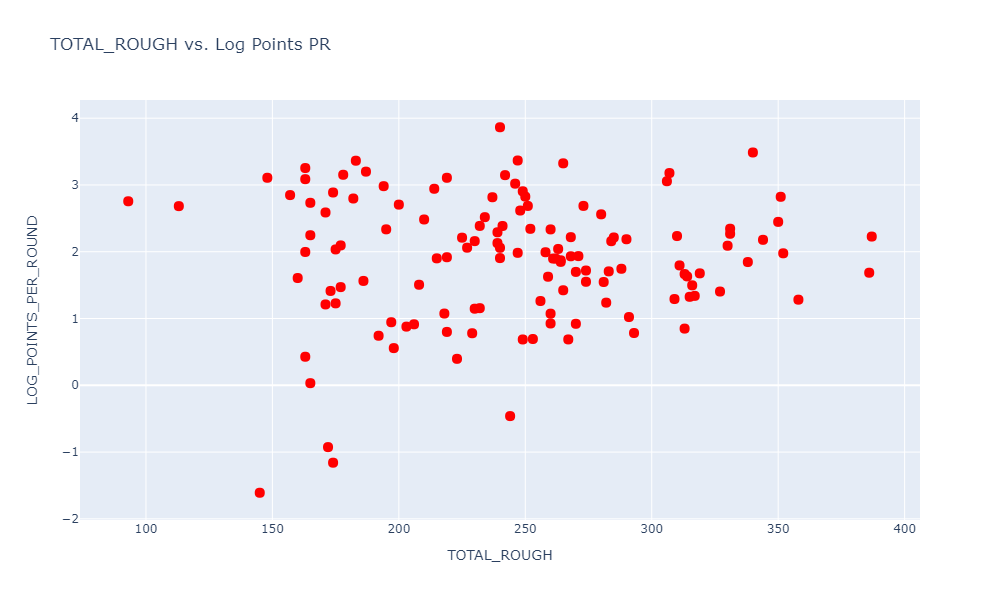

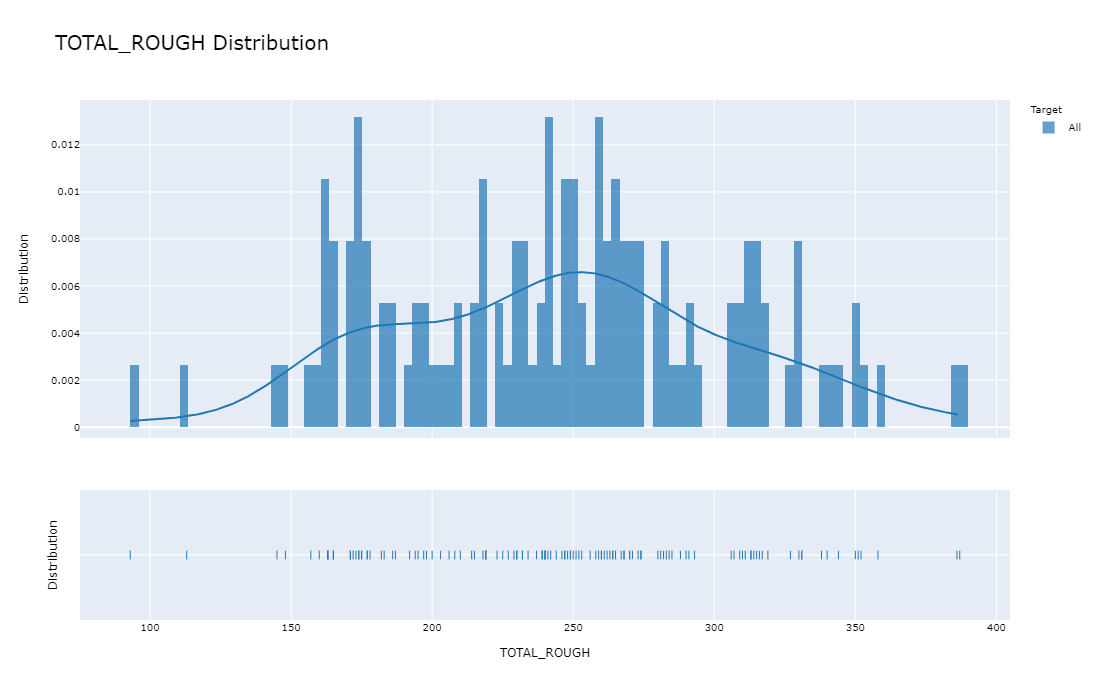

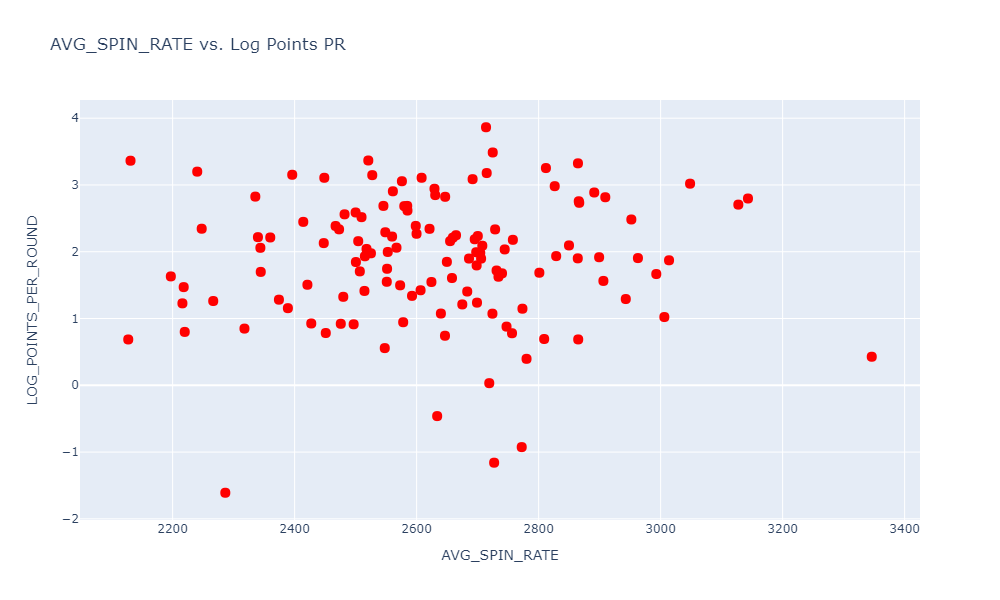

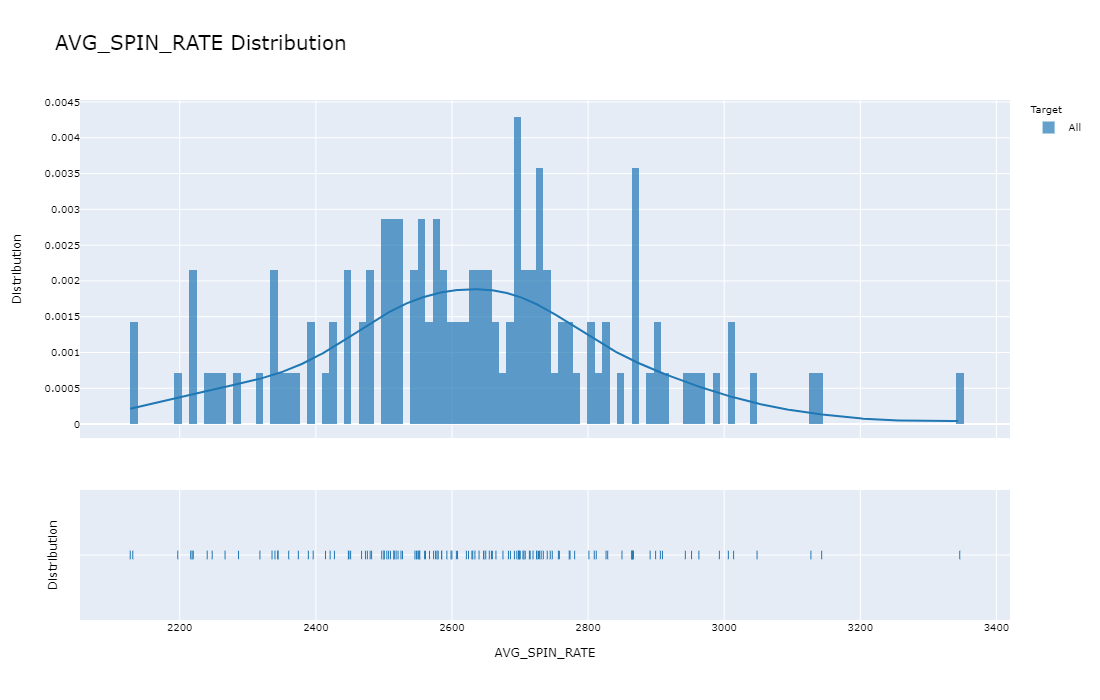

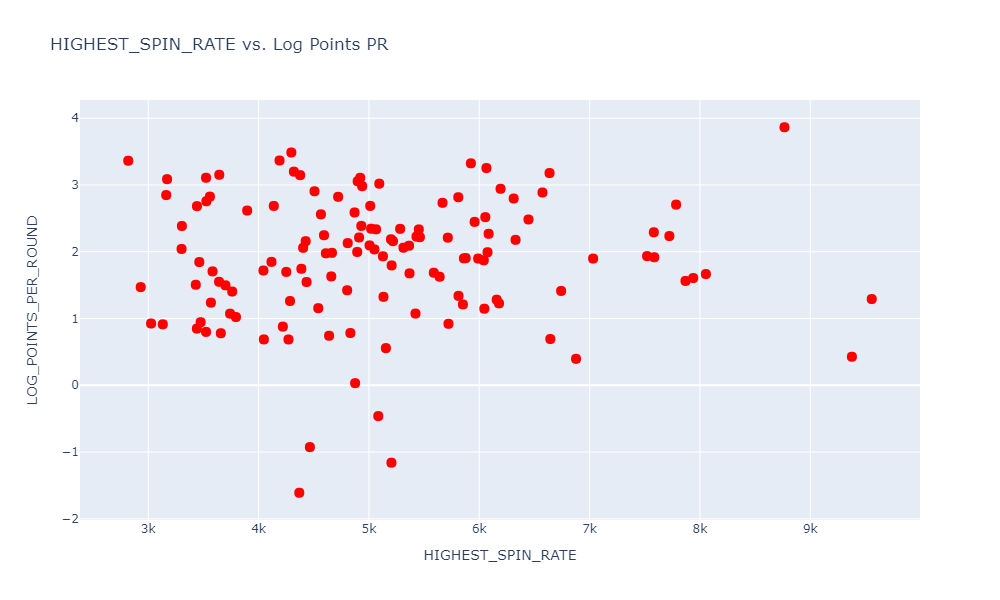

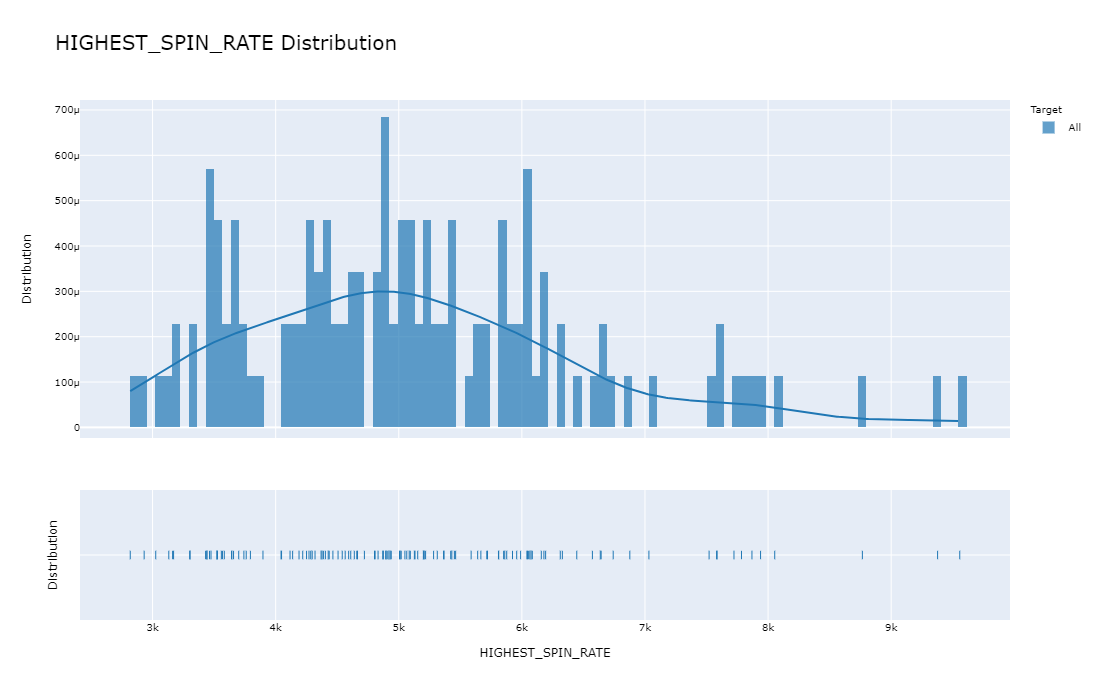

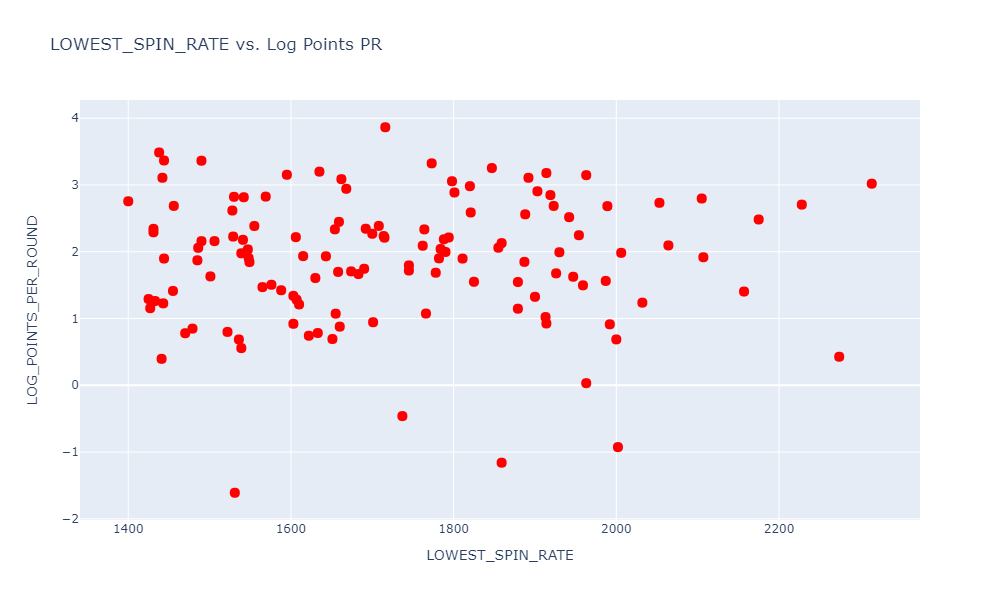

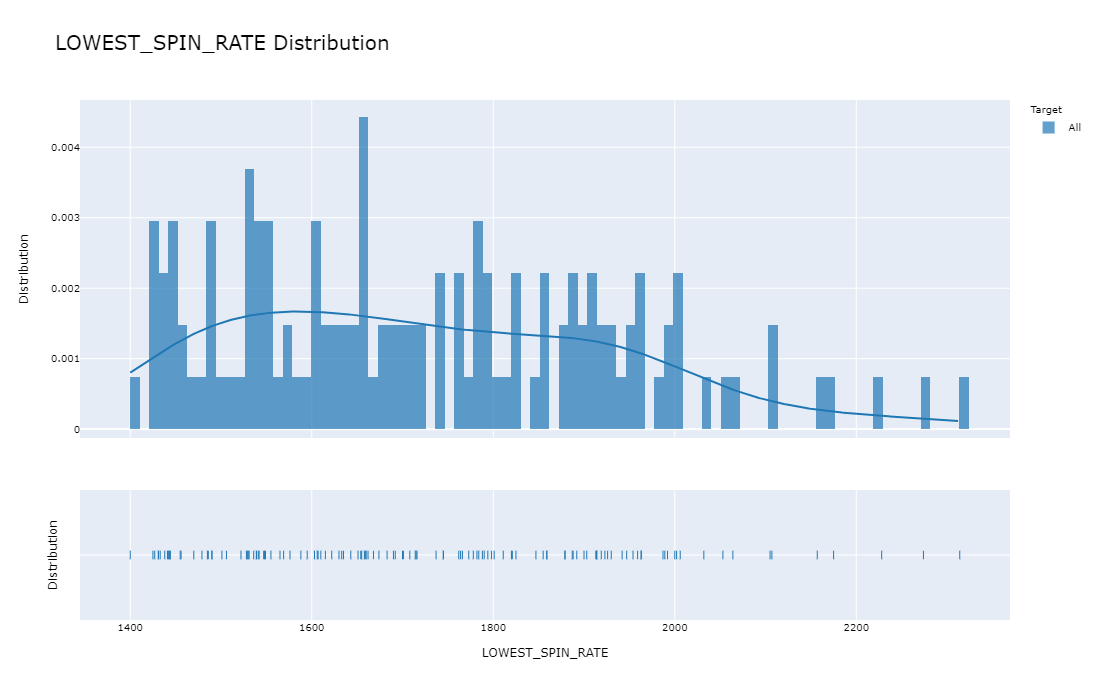

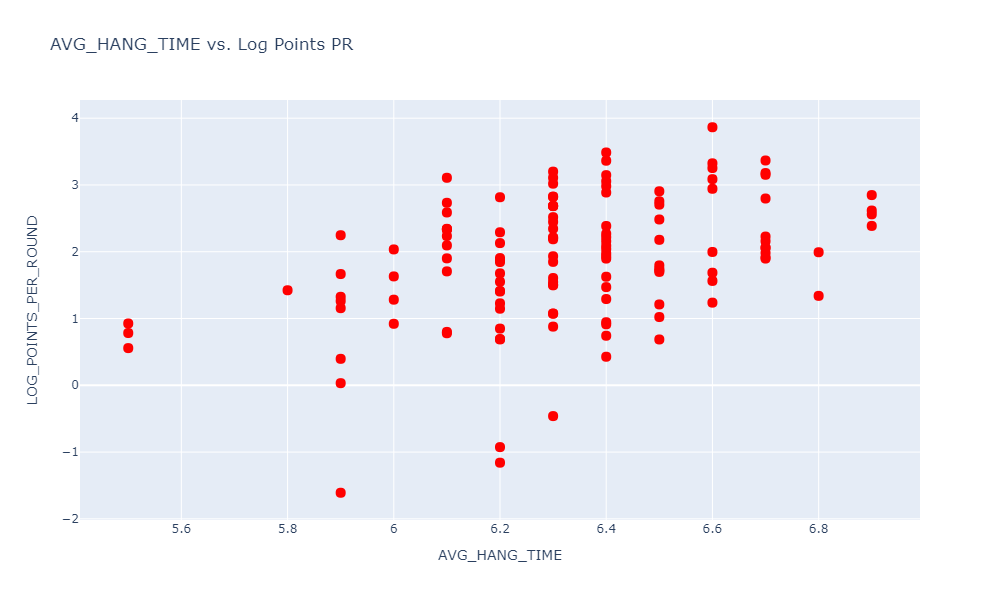

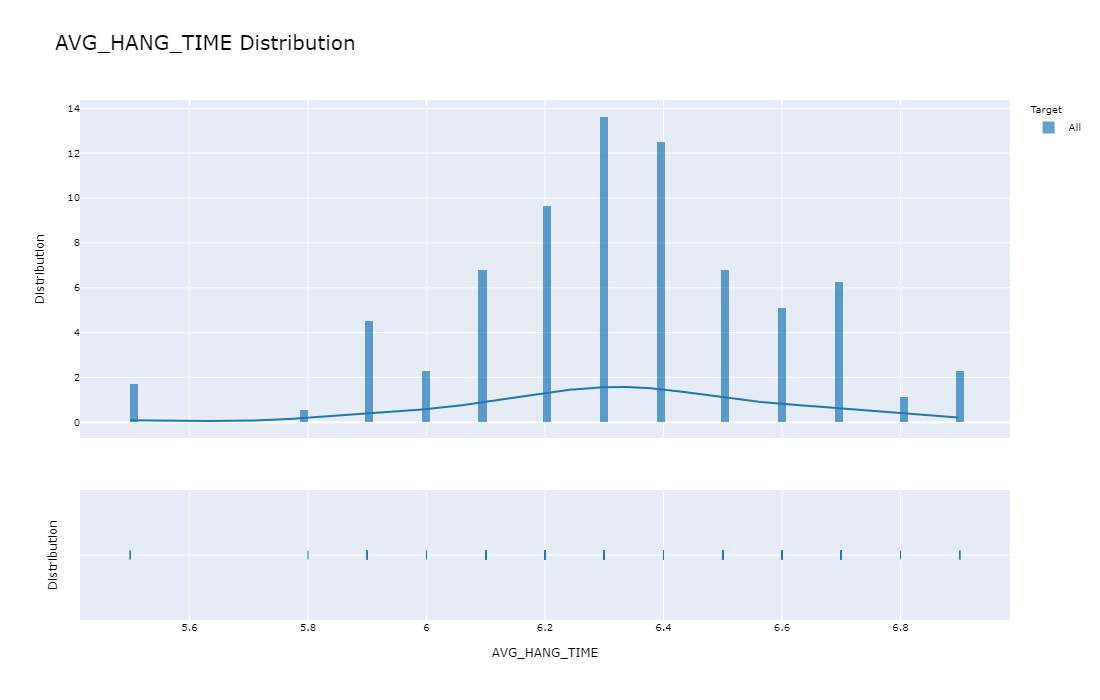

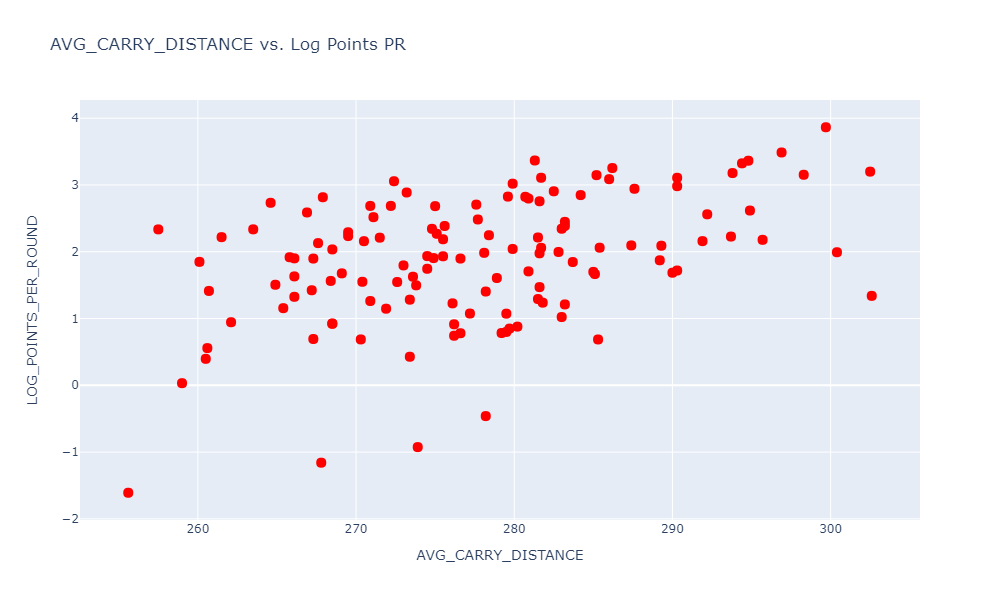

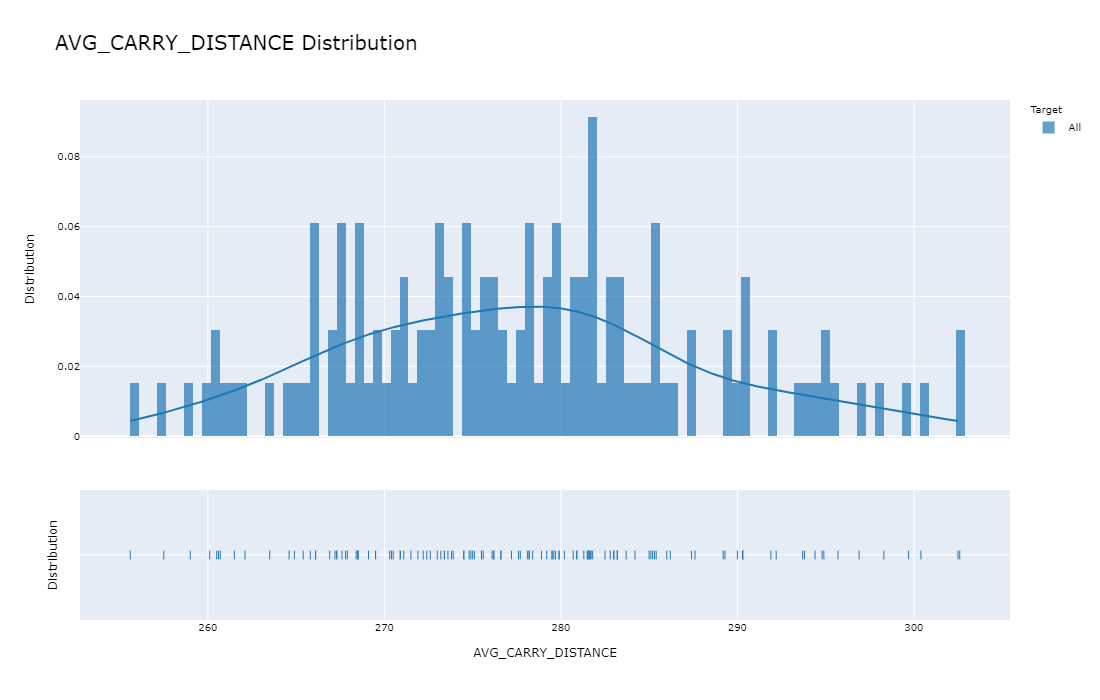

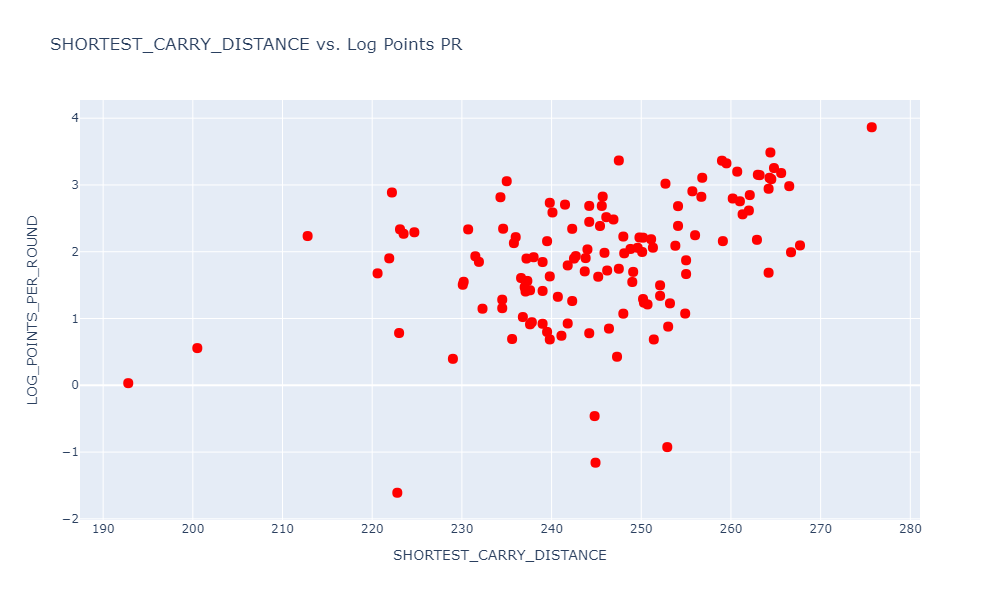

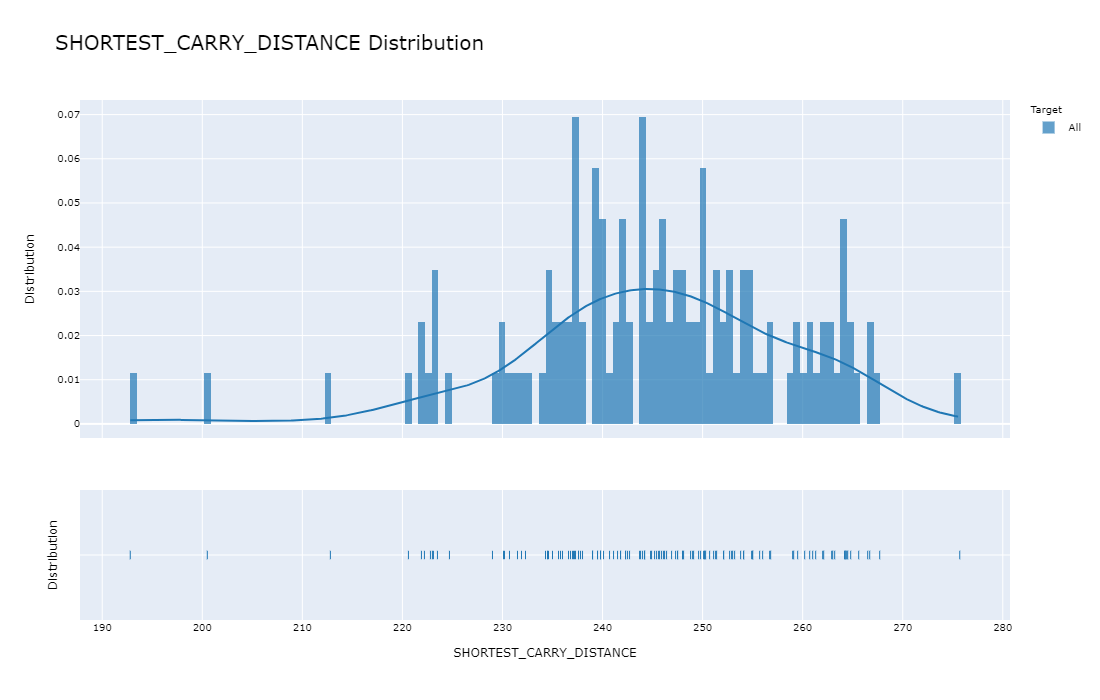

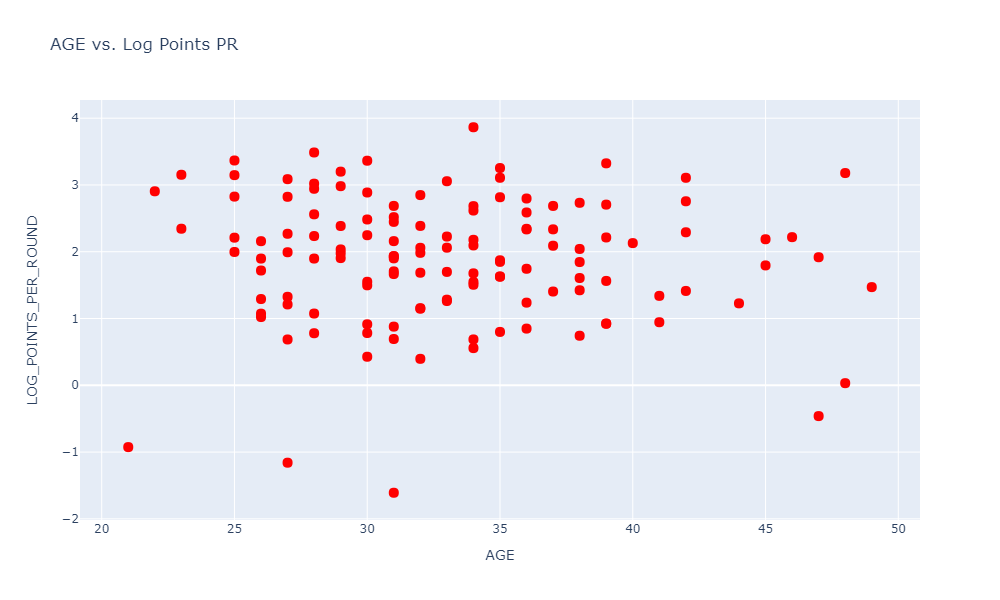

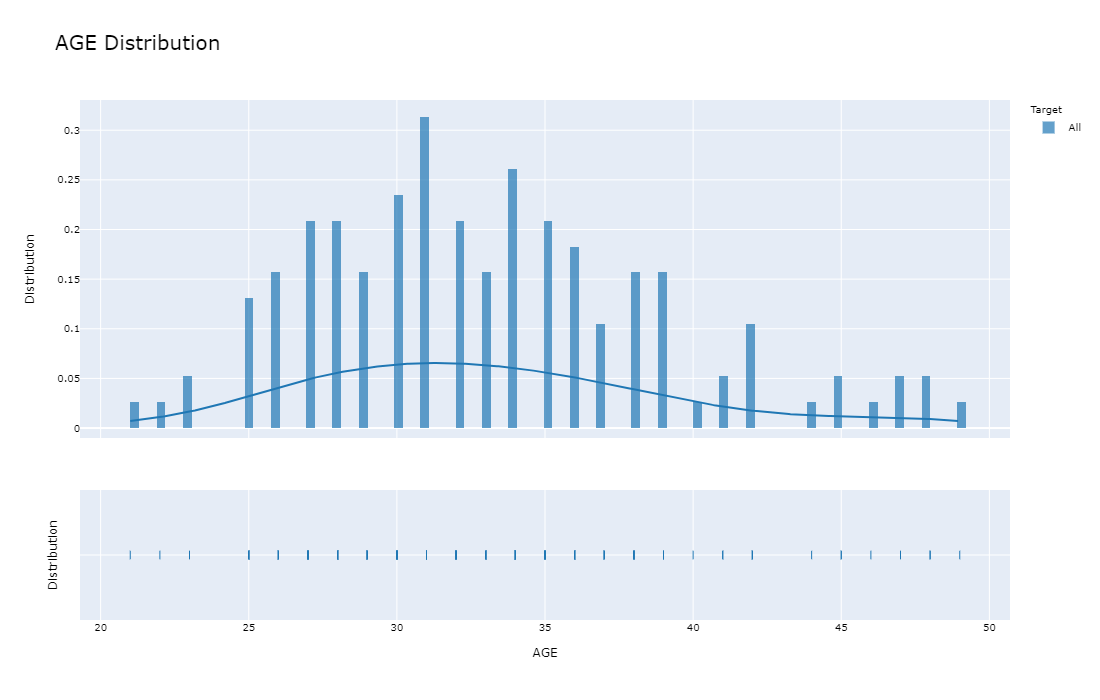

In [16]:
for Variable in ImportantFeatures:
    Scatter(Train, Variable, "LOG_POINTS_PER_ROUND", str(Variable) + " vs. Log Points PR")
    DistributionPlot(Train, Variable)

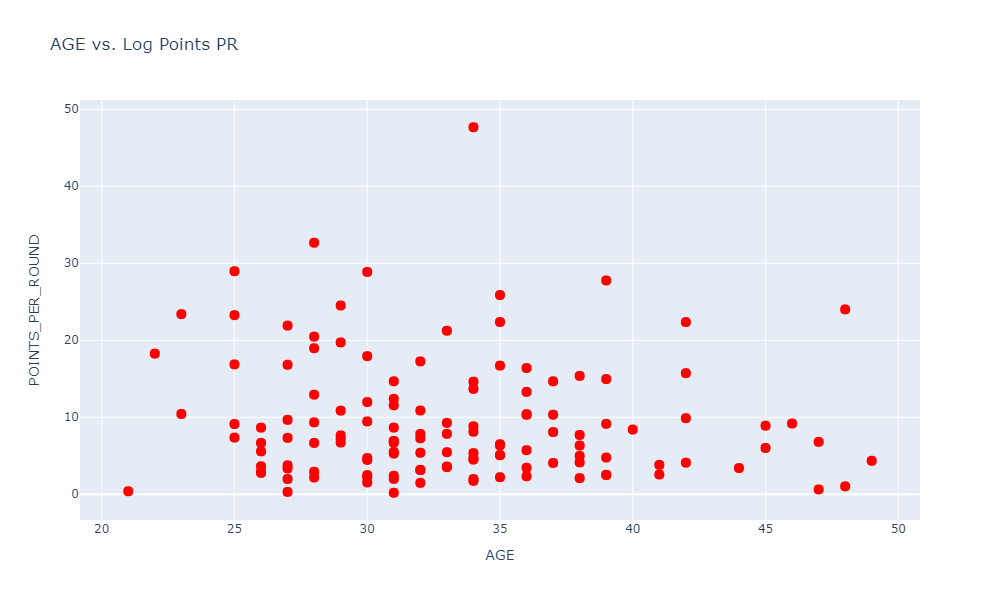

In [17]:
Scatter(Train, Variable, "POINTS_PER_ROUND", str(Variable) + " vs. Log Points PR")